### Saurabh Chatterjee
### chatterjeesaurabh38@gmail.com

In [1]:
from operator import rshift
import cv2 as cv
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
import pandas as pd
import math
import time
import csv
from scipy.signal import filtfilt

from kalman_filter import KalmanFilter

In [2]:
video_fps = 120                # Change as per Camera FPS used to capture video
del_time = 1/video_fps


mp_face_mesh = mp.solutions.face_mesh         # Face mesh landmarks object

# Left Eye Upper: 398, 384, [385], [386], 387, 388, 466              (left to right)
# Left Eye Lower: 362, 382, 381, [380], 374, [373], 390, 249, 263    (left to right)

LEFT_EYE = [ 362, 382, 381, 380, 374, 373, 390, 249, 263, 466, 388, 387, 386, 385,384, 398 ]
RIGHT_EYE = [ 33, 7, 163, 144, 145, 153, 154, 155, 133, 173, 157, 158, 159, 160, 161, 246 ]

LEFT_IRIS = [474,475, 476, 477]
RIGHT_IRIS = [469, 470, 471, 472]

# Eye Corners:
R_H_LEFT = [33] # right eye right most landmark
R_H_RIGHT = [133] # right eye left most landmark
L_H_LEFT = [362] # left eye right most landmark
L_H_RIGHT = [263] # left eye left most landmark

# Eyelids: (upper two) - (lower two) - (eye corners) points: for *BLINK Detection*
EYELID_LEFT = [385, 386, 380, 374, 362, 263]


def euclidean_distance(point1, point2):
    x1, y1 = point1.ravel()
    x2, y2 = point2.ravel()
    distance = math.sqrt((x2-x1)**2 + (y2-y1)**2)
    return distance

def iris_position(iris_center, left_point, right_point):
    center_to_left_dist = euclidean_distance(iris_center, left_point)
    total_distance = euclidean_distance(right_point, left_point)
    norm_dist = center_to_left_dist/total_distance


start_time = time.time()


def calculate_relative_coordinates(iris_center, eye_corner1, eye_corner2, frame_time, ear):
    # Calculate New iris center Coordinates wrt Eye Corner, with line joining the two corners as new x-axis, one of the eye corner as origin
    # Calculate the vector components of the line connecting the two eye corners
    delta_x = eye_corner2[0] - eye_corner1[0]
    delta_y = eye_corner2[1] - eye_corner1[1]
    delta = math.sqrt(delta_x**2 + delta_y**2)

    # Calculate the relative coordinates of the iris center

    x_2 = iris_center[0] - eye_corner1[0]    #
    y_2 = iris_center[1] - eye_corner1[1]    #
    relative_x_2 = ((iris_center[0] - eye_corner1[0]) * delta_x + (iris_center[1] - eye_corner1[1]) * delta_y)/delta  #
    relative_y_2 = (-(iris_center[0] - eye_corner1[0]) * delta_y + (iris_center[1] - eye_corner1[1]) * delta_x)/delta  #

    relative_x = ((iris_center[0] - eye_corner1[0]) * delta_x + (iris_center[1] - eye_corner1[1]) * delta_y)/delta**2   #  Again divided by delta to Normalise the eye x-movement between 0-1
    relative_y = (-(iris_center[0] - eye_corner1[0]) * delta_y + (iris_center[1] - eye_corner1[1]) * delta_x)/delta**2  # Again divided by delta (NOT delta/4) to Normalise the eye y-movement between 0-1 

    # Calculate the distance and angle in the new coordinate system
    #distance = math.sqrt(relative_x ** 2 + relative_y ** 2)
    #angle = math.atan2(relative_y, relative_x)
    
    return relative_x, relative_y, frame_time, delta, x_2, y_2, relative_x_2, relative_y_2, iris_center[0], iris_center[1], ear



def calculate_distance(point1, point2):
    """Calculate the Euclidean distance between two points."""
    x1, y1 = point1
    x2, y2 = point2

    delta_x = x2-x1
    delta_y = y2-y1

    return math.sqrt((delta_x)**2 + (delta_y)**2), delta_x, delta_y


# define EAR (Eyes Aspect Ratio) function
def eye_aspect_ratio(eyelids_coords):
    # compute the euclidean distances between the two sets of vertical eye landmarks (x, y)-coordinates
    A,_,_ = calculate_distance(eyelids_coords[0], eyelids_coords[2])
    B,_,_ = calculate_distance(eyelids_coords[1], eyelids_coords[3])        # Vertical distance between center of upper and lower eyelids

    # compute the euclidean distance between the horizontal eye landmark (x, y)-coordinates (Eye-Corners)
    C,_,_ = calculate_distance(eyelids_coords[4], eyelids_coords[5])

    # compute the eye aspect ratio
    # ear = (A + B) / (2 * C)
    ear = B/C
    
    return ear

### Record Video: Store Iris Center Coordinates and EAR Values

In [67]:
center_left = [0, 0]              # Declaring them Global Variables, so that if in a frame loop eye is not detected then they take last updated values
left_eye_left_corner = [0, 0]
left_eye_right_corner = [0, 0]

iris_relative_coords = []    # Stores Iris Center locations from each frame

ear = 0   # Eye Aspect Ratio (EAR)
ear_list = []

prev_frame_time = 0
new_frame_time = 0


cap = cv.VideoCapture('Parth_5.mp4')       # Read a Video file
#cap = cv.VideoCapture(0)                       # Capture Video from Webcam
# cap = cv.VideoCapture('Dataset_Single Fixation_720p_120fps.mp4')   # Use for Error Calliberation** : ask user to fix gaze for few secs and record video: read that video
#cap = cv.VideoCapture('http://192.168.42.129:8080/video')
#cap = cv.VideoCapture('60_fps_face_video.mp4')


# fourcc = cv.VideoWriter_fourcc(*'XVID')               #
# output_file = 'output_video.mp4'                       #
# video_writer = cv.VideoWriter(output_file, fourcc, 30, (640, 480))      #

frame_time = start_time

with mp_face_mesh.FaceMesh(
    max_num_faces=1,
    refine_landmarks=True,      # Get 478 landmarks (instead of 468): 10 more for IRIS landmarks**
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
) as face_mesh:
    while True:
        ret, frame = cap.read()
        frame = cv.convertScaleAbs(frame, alpha=1, beta=0)   # alpha - Scaling Factor (Contrast),   beta - Offset (Brightness)(-25 to make pupil absolute intensity)

        if not ret:
            break

        # frame = cv.flip(frame, 1)     # Flip image so the frame does not appear mirror image
        rgb_frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)    # cv2 takes BGR images - Convert to RGB for mediapipe
        img_h, img_w = frame.shape[:2]


        results = face_mesh.process(rgb_frame)   # Activate face_mesh to produce face landmarks on the image # Output is Normalised bw 0-1

        if results.multi_face_landmarks:
            #print(results.multi_face_landmarks[0].landmark)

            # Multiply by frame width-height to get landmarks values in pixels:
            mesh_points = np.array([np.multiply([p.x, p.y], [img_w, img_h]).astype(int) for p in results.multi_face_landmarks[0].landmark])  
            # print(mesh_points)
            cv.polylines(frame, [mesh_points[LEFT_EYE]], True, (0,255,0), 1, cv.LINE_AA)
            cv.polylines(frame, [mesh_points[RIGHT_EYE]], True, (0,255,0), 1, cv.LINE_AA)
            (l_cx, l_cy), l_radius = cv.minEnclosingCircle(mesh_points[LEFT_IRIS])
            (r_cx, r_cy), r_radius = cv.minEnclosingCircle (mesh_points[RIGHT_IRIS])
            center_left = np.array([l_cx, l_cy], dtype=np.int32)
            center_right = np.array([r_cx, r_cy], dtype=np.int32)

            cv.circle(frame, center_left, int(l_radius), (0,0,255), 1, cv.LINE_AA)    # Draw circle on Iris
            cv.circle(frame, center_right, int(r_radius), (255,0,0), 1, cv.LINE_AA)

            left_eye_left_corner = mesh_points[L_H_LEFT][0]
            left_eye_right_corner = mesh_points[L_H_RIGHT][0]

            cv.circle(frame, left_eye_left_corner, 2, (0,255,255), -1, cv.LINE_AA)   # Draw circle on Eye Corner
            cv.circle(frame, left_eye_right_corner, 2, (255,255,255), -1, cv.LINE_AA)


            ear = eye_aspect_ratio(mesh_points[EYELID_LEFT])  # Eye Aspect Ratio: using ratio inter-EYELID distance and eye-corner distance
            ear_list.append(ear)
        

        
        iris_relative_coords.append(calculate_relative_coordinates(center_left, left_eye_left_corner, left_eye_right_corner, frame_time, ear))
        frame_time = frame_time + 1/video_fps      # since frame rate is fixed (depends on fps of recorded video)

        # For FPS Display:
        new_frame_time = time.time()
        time_diff = new_frame_time-prev_frame_time
        fps = 1/(time_diff)
        prev_frame_time = new_frame_time
    
        # converting the fps into integer
        fps = int(fps)
        # converting the fps to string so that we can display it on frame by using putText function
        fps = str(fps)

        # putting the FPS count on the frame
        cv.putText(frame, fps, (7, 70), cv.FONT_HERSHEY_SIMPLEX, 2, (100, 255, 0), 3, cv.LINE_AA)


        cv.imshow('img', frame)

        #video_writer.write(frame)   #

        if cv.waitKey(1) & 0xFF == ord('q'):
            break

iris_relative_coords_array = np.array(iris_relative_coords)

# csv_fields = ['relative_x', 'relative_y', 'frame_time', 'delta', 'x_2', 'y_2', 'relative_x_2', 'relative_y_2', 'iris_center_x', 'iris_center_y']
# csv_filename = "eye_data.csv"  

# with open(csv_filename, "w", newline="") as file:
#     writer = csv.writer(file)
#     writer.writerow(csv_fields)
#     writer.writerows(iris_relative_coords)



#video_writer.release()
cap.release()
cv.destroyAllWindows()

### Moving Average Filter: to reduce noise

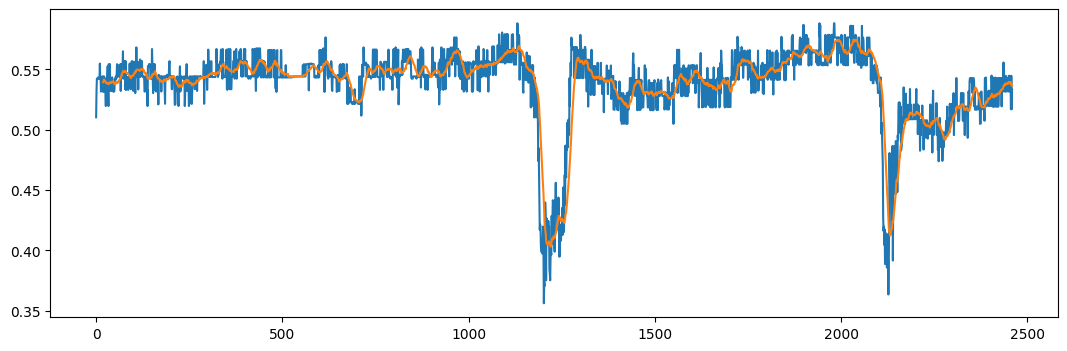

In [68]:
# Moving Average Filter: to reduce noise
window_size = 20        # 15


def weighted_mean(seq):
    weights = [1]*window_size                   # window list of 'ones'
    return np.average(seq, weights=weights)     # multiply 'ones' window to a sequence

# apllying ROLLING AVERAGE operation on a dataframe: ".apply(weighted_mean, raw=True)" applies a function (=weighted_mean) over a dataframe "rollingly"
def rolling_numba(dataframe, window_size):
    return dataframe.rolling(window_size, axis=0).apply(weighted_mean, raw=True)   # if slow then remove 'engine="numba"' from .apply()


def moving_average(array, window_size):
    iris_relative_coords_df = pd.DataFrame(array)       # convert numpy array to pandas DataFrame

    iris_relative_coords_filtered_df = rolling_numba(iris_relative_coords_df, window_size)      # apply rolling average: returns a DataFrame

    iris_relative_coords_filtered_array = (iris_relative_coords_filtered_df[window_size-1:][:]).to_numpy()  # remove top 'NaN' rows & convert back to numpy array

    # display(iris_relative_coords_filtered_df.to_string())
    # display(iris_relative_coords_df.to_string())
    # print(iris_relative_coords_filtered_array)
    ax = iris_relative_coords_df[0].plot(figsize=(13,4))        # PLOT comparison of original x-data and filtered x-data
    iris_relative_coords_filtered_df[0].plot(ax=ax)

    return iris_relative_coords_filtered_array          # returns NumPy Array


# Applying Moving Average to Iris Coordinates:
iris_relative_coords_filtered_array = moving_average(iris_relative_coords_array[:,:2], window_size)     # apply moving average


### Butterworth FIR Low-Pass Filter:

<Axes: >

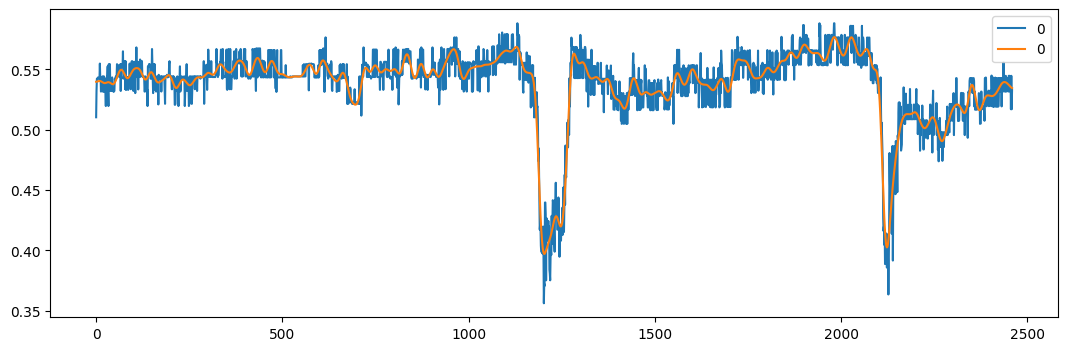

In [69]:
from scipy.signal import butter, sosfiltfilt, sosfilt, filtfilt

def lowpass_filter(signal, order, cutoff_freq, sampling_rate):
    sos = butter(N=order, Wn=cutoff_freq, fs=sampling_rate, btype='lowpass', output='sos')
    lpf_filtered_signal = sosfiltfilt(sos, signal, padtype='even')

    return(lpf_filtered_signal)


lpf_order = 4           
lpf_cutoff_freq = 4     # in (Hz)
sampling_rate = video_fps
iris_relative_coords_lpf_filtered_array_x = lowpass_filter(iris_relative_coords_array[:,0], lpf_order, lpf_cutoff_freq, sampling_rate)
iris_relative_coords_lpf_filtered_array_y = lowpass_filter(iris_relative_coords_array[:,1], lpf_order, lpf_cutoff_freq, sampling_rate)


# Final Butterworth LPF Filtered Coordinates Array ** :
iris_relative_coords_LPF_filtered_array = np.stack((iris_relative_coords_lpf_filtered_array_x, iris_relative_coords_lpf_filtered_array_y), axis=1)


iris_relative_coords_df = pd.DataFrame(iris_relative_coords_array[:,0])
iris_relative_coords_lpf_filtered_array_x_df = pd.DataFrame(iris_relative_coords_lpf_filtered_array_x)
ax = iris_relative_coords_df.plot(figsize=(13,4))        # PLOT comparison of original x-data and filtered x-data
iris_relative_coords_lpf_filtered_array_x_df.plot(ax=ax)

# print(np.shape(iris_relative_coords_LPF_filtered_array))

#### Applying Moving Average to EAR

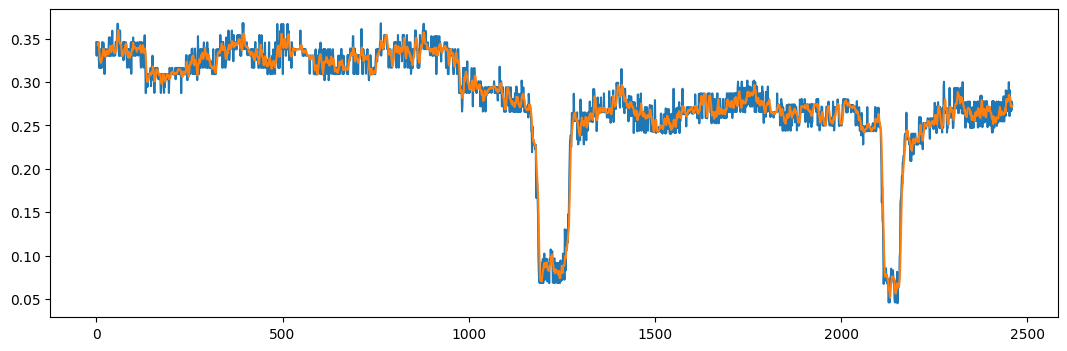

In [70]:
# Applying Moving Average to EAR (denotes distance between Eyelids):
window_size=5
ear_list_smoothed = moving_average(ear_list, window_size)

# ear_list_smoothed = ear_list_smoothed[int((15-5)/2) : -int((15-5)/2)]     # When - *Moving Average Filter used in Iris-Coords Array

In [71]:
print(len(iris_relative_coords_LPF_filtered_array))

2460


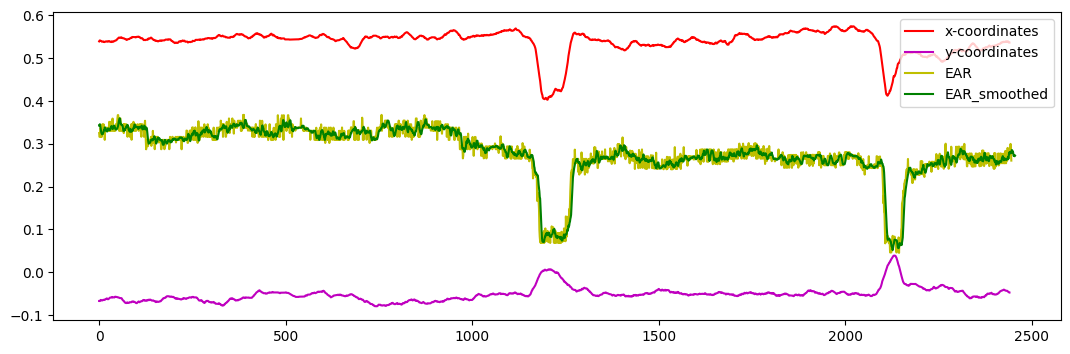

In [72]:
plt.figure(figsize=(13,4))
plt.plot(iris_relative_coords_filtered_array[:,0], color='r', label='x-coordinates')
plt.plot(iris_relative_coords_filtered_array[:,1], color='m', label='y-coordinates') 
plt.plot(ear_list[7:-7], color='y', label='EAR') 
plt.plot(ear_list_smoothed, color='g', label='EAR_smoothed') 

plt.legend()
plt.show()

### RUN THIS ONCE ONLY - with a Fixation Video only
#### For calculating Saccades THRESHOLD: [Keep looking at a single point (DON'T BLINK) for few seconds]

In [66]:
# **RUN THIS ONCE ONLY - Not at every full run of the Code**
# For calculating Saccades THRESHOLD: [Keep looking at a single point (DON'T BLINK) for few seconds and stop the code]

def estimate_threshold(x_coords, y_coords):     # [First Keep looking at a single point (DON'T BLINK) for few seconds and stop the code]
    sq_sum_x = 0
    sq_sum_y = 0

    for i in range(1, len(x_coords)):
        dx = x_coords[i]-x_coords[i-1]
        dy = y_coords[i]-y_coords[i-1]
        sq_sum_x += np.square(dx)
        sq_sum_y += np.square(dy)

    threshold_x = np.sqrt(sq_sum_x/(len(x_coords)-1))   #RMSE
    threshold_y = np.sqrt(sq_sum_y/(len(x_coords)-1))

    return threshold_x, threshold_y


threshold_x, threshold_y = estimate_threshold(iris_relative_coords_filtered_array[:,0], iris_relative_coords_filtered_array[:,1])

print(f'Threshold X: {threshold_x} , Threshold Y: {threshold_y}')


''' *** After this, go back to the 3rd cell to load your main video for eye tracking analysis *** '''

Threshold X: 0.0004076286963944122 , Threshold Y: 0.00048343758980212676


' *** After this, go back to the 3rd cell to load your main video for eye tracking analysis *** '

### Adaptive EAR Threshold 

In [16]:
# Adaptive EAR Threshold:
ear_min = min(ear_list_smoothed)
ear_max = max(ear_list_smoothed)

ear_threshold = (ear_min + ear_max)/2

### Kalman Filter (SKIP THIS)

In [18]:
# Coordinate data reconstruction during Blink using Kalman Filter:

num_steps = len(iris_relative_coords_filtered_array)

ini_pos = iris_relative_coords_filtered_array[0]        # initial position [x0, y0]

_, dx_0, dy_0 = calculate_distance(iris_relative_coords_filtered_array[0], iris_relative_coords_filtered_array[1])
vx_0 = dx_0 / del_time          # del_time = 1/Video_FPS  (Fixed)
vy_0 = dy_0 / del_time
ini_vel = [vx_0, vy_0]                                  # initial velocity 


# Kalman Filter Initialization
A = np.array([[1,0,1,0], [0,1,0,1], [0,0,1,0], [0,0,0,1]])                          # State transition matrix
B = np.array([[0], [0], [0], [0]])                                                  # No control input
u = np.array([[0]])                                                                 # No control input
H = np.array([[1,0,0,0], [0,1,0,0]])                                                # Measurement function
Q = np.array([[threshold_x**2*5, 0, 0, 0], [0,threshold_y**2*10,0,0], [0, 0, threshold_x**2*5, 0], [0,0,0,threshold_y**2*10]])     # Process noise covariance
R = np.array([[threshold_x**2, 0], [0, threshold_y**2*20]])                         # Measurement noise covariance
x0 = np.array([[ini_pos[0]], [ini_pos[1]], [ini_vel[0]], [ini_vel[1]]])             # Initial state estimate
P0 = np.array([[threshold_x**2*10, 0, 0, 0], [0,threshold_y**2*10,0,0], [0, 0, threshold_x**2*10, 0], [0,0,0,threshold_y**2*10]])   # Initial estimate covariance


kf = KalmanFilter(A, B, u, H, Q, R, x0, P0)

# Allocate space for estimated positions and velocities
estimated_positions_x = np.zeros(num_steps)
estimated_positions_y = np.zeros(num_steps)
estimated_velocities_x = np.zeros(num_steps)
estimated_velocities_y = np.zeros(num_steps)

# Kalman Filter Loop
for t in range (num_steps):
    # Predict
    kf.predict()

    # Update
    measurement = np.array([[iris_relative_coords_filtered_array[t, 0]], [iris_relative_coords_filtered_array[t, 1]]])
    kf.update(measurement)
    
    # Store the filtered position and velocity
    estimated_positions_x[t] = kf.x[0]
    estimated_positions_y[t] = kf.x[1]
    estimated_velocities_x[t] = kf.x[2]
    estimated_velocities_y[t] = kf.x[3]


In [ ]:
# Actual vs Predicted by Kalman-filter:

plt.figure(figsize=(13,4))
plt.plot(estimated_positions_x, color='r', label='kalman-predicted') 
plt.plot(iris_relative_coords_filtered_array[:,0], color='y', label='x-coordinates') 

plt.xlabel('Frame')
plt.ylabel('X-coordinate')
plt.legend()
plt.show()

### Storing Blink Start and End Indices: Threshold Based (SKIP THIS)

In [ ]:
# Storing Blink Start and End Indices: to be used to predict coords during Blink duration using Cubic Spline Interpolation
'''(Adaptive Threshold Based:  **to be used for "X"-Coords Interpolation ONLY)'''

blink_start_frame_index = []
blink_end_frame_index = []

blink_start = False
blink_end = False

for i in range (len(ear_list_smoothed)):
    if ((ear_list_smoothed[i] < ear_threshold) and blink_start==False):
        blink_start_frame_index.append(i)
        blink_start = True
        blink_end = True
    
    if ((ear_list_smoothed[i] >= ear_threshold) and blink_end==True):
        blink_end_frame_index.append(i)
        blink_start = False
        blink_end = False 

print('blink_start_frame_index: ', blink_start_frame_index)
print('blink_end_frame_index: ', blink_end_frame_index)

### Storing Blink Start and End Indices: Derivative Based

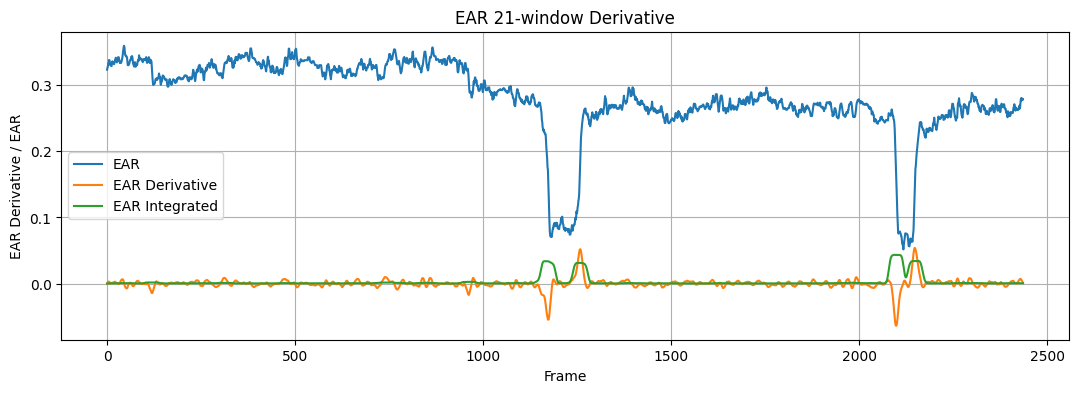

In [17]:
# ACTUAL Blink Start and End Indices:
'''storing exact indices where blink starts and ends: to be used to REMOVE Y-Coords during this whole time (since has highest noise during blink)'''

ear_derivative = []

# 1st - Take Window Derivative**: 
''' 21-Window Derivative : '''
for i in range(10, len(ear_list_smoothed)-10):      #
        ear_derivative.append((ear_list_smoothed[i+1][0] + ear_list_smoothed[i+2][0] + ear_list_smoothed[i+3][0] + ear_list_smoothed[i+4][0] + ear_list_smoothed[i+5][0] + ear_list_smoothed[i+6][0] + ear_list_smoothed[i+7][0] + ear_list_smoothed[i+8][0] + ear_list_smoothed[i+9][0] + ear_list_smoothed[i+10][0] - ear_list_smoothed[i-10][0] - ear_list_smoothed[i-9][0] - ear_list_smoothed[i-8][0] - ear_list_smoothed[i-7][0] - ear_list_smoothed[i-6][0] - ear_list_smoothed[i-5][0] - ear_list_smoothed[i-4][0] - ear_list_smoothed[i-3][0] - ear_list_smoothed[i-2][0] - ear_list_smoothed[i-1][0]) / 22)      #

# 2nd - Then take Square**:
ear_rate_change_sq = list(np.square(ear_derivative))
ear_rate_change_sq = [0]*20 + ear_rate_change_sq + [0]*20

ear_rate_change_integrated = []

# 3rd - Then take Window Integration**:
for i in range (20, len(ear_rate_change_sq)-20):
        ear_rate_change_integrated.append(sum(ear_rate_change_sq[i-20: i+20]))

plt.figure(figsize=(13,4))
plt.plot(ear_list_smoothed[10:-10], label='EAR')
plt.plot(ear_derivative, label='EAR Derivative')
# plt.plot(ear_rate_change_sq)
plt.plot(ear_rate_change_integrated, label='EAR Integrated')
plt.xlabel('Frame')
plt.ylabel('EAR Derivative / EAR')
plt.title('EAR 21-window Derivative')
plt.legend()
plt.grid()

ear_rate_change_integrated_threshold = 0.003     ### 


2456
2436
2436
[5.6424303670375474e-05, 6.377455992475122e-05, 7.097427099266384e-05, 7.665216065221675e-05, 7.996242401172192e-05, 8.140497630191062e-05, 8.222856438970869e-05, 8.289588659102698e-05, 8.333242892590998e-05, 8.350248835426206e-05, 8.350435232671012e-05, 8.388678156239642e-05, 8.46454574376858e-05, 8.508899135430035e-05, 8.509220388705191e-05, 8.651127678117339e-05, 9.370803668127079e-05, 0.0001089236308267518, 0.00013175740253882915, 0.00016155590743572557, 0.00019611604550053423, 0.00023626308257847456, 0.0002777905699280196, 0.00031435191219308315, 0.0003368654014916708, 0.00034155704503445266, 0.000334463544733492, 0.00033011380985538413, 0.0003383379435161822, 0.0003597169572761814, 0.00039331814851657776, 0.00043700863755392243, 0.00048768401409664887, 0.0005414091517912087, 0.0005933541596400969, 0.0006341429740684014, 0.0006578644496891598, 0.0006654169434914353, 0.0006641135290113216, 0.0006601018873058816, 0.000654736961658873, 0.0006486011159433406, 0.00064286

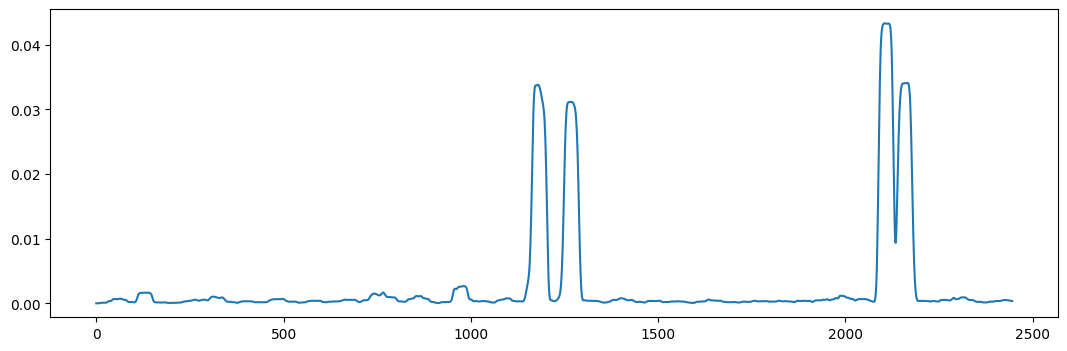

In [18]:
print(len(ear_list_smoothed))
print(len(ear_derivative))
print(len(ear_rate_change_integrated))
print(ear_rate_change_integrated)

ear_rate_change_integrated_temp = [0]*10 + ear_rate_change_integrated
plt.figure(figsize=(13,4))
plt.plot(ear_rate_change_integrated_temp)

In [22]:
''' Actual Strict Blink Start and End Index:  ** '''

# Setting a Threshold:      **(PARAMETER: Adjust to get acurate blink detection)
ear_rate_change_integrated_threshold = 0.005     ### 0.005      **(PARAMETER: Adjust to get acurate blink detection)

blink_actual_start_frame_index = []
blink_actual_end_frame_index = []

blink_actual_start = False
blink_actual_end = False

for i in range (len(ear_rate_change_integrated)):
    if ((ear_rate_change_integrated[i] > ear_rate_change_integrated_threshold) and blink_actual_start==False):
        blink_actual_start_frame_index.append(i+10)
        blink_actual_start = True
        blink_actual_end = True
    
    if ((ear_rate_change_integrated[i] <= ear_rate_change_integrated_threshold) and blink_actual_end==True):
        blink_actual_end_frame_index.append(i+10)
        blink_actual_start = False
        blink_actual_end = False 


# blink_actual_start_frame_index = [1152, 2083]       # Delete this
# blink_actual_end_frame_index = [1295, 2186]         # Delete this

print('blink_actual_start_frame_index: ', blink_actual_start_frame_index)
print('blink_actual_end_frame_index: ', blink_actual_end_frame_index)

blink_actual_start_frame_index:  [1152, 2083]
blink_actual_end_frame_index:  [1295, 2186]


### Blink Duration Coordinates Prediction: using Kalman Filter (SKIP THIS)

In [ ]:
# Coordinate data reconstruction during Blink using Kalman Filter:


num_steps = len(iris_relative_coords_filtered_array)

ini_pos = iris_relative_coords_filtered_array[0]        # initial position [x0, y0]

_, dx_0, dy_0 = calculate_distance(iris_relative_coords_filtered_array[0], iris_relative_coords_filtered_array[1])
vx_0 = dx_0 / del_time          # del_time = 1/Video_FPS  (Fixed)
vy_0 = dy_0 / del_time
ini_vel = [vx_0, vy_0]                                  # initial velocity 


# Kalman Filter Initialization
A = np.array([[1,0,1,0], [0,1,0,1], [0,0,1,0], [0,0,0,1]])                          # State transition matrix
B = np.array([[0], [0], [0], [0]])                                                  # No control input
u = np.array([[0]])                                                                 # No control input
H = np.array([[1,0,0,0], [0,1,0,0]])                                                # Measurement function
Q = np.array([[threshold_x**2*500, 0, 0, 0], [0,threshold_y**2*1000,0,0], [0, 0, threshold_x**2*50, 0], [0,0,0,threshold_y**2*100]])     # Process noise covariance
R = np.array([[threshold_x**2, 0], [0, threshold_y**2*20]])                         # Measurement noise covariance
x0 = np.array([[ini_pos[0]], [ini_pos[1]], [ini_vel[0]], [ini_vel[1]]])             # Initial state estimate
P0 = np.array([[threshold_x**2*10, 0, 0, 0], [0,threshold_y**2*10,0,0], [0, 0, threshold_x**2*10, 0], [0,0,0,threshold_y**2*10]])   # Initial estimate covariance


kf = KalmanFilter(A, B, u, H, Q, R, x0, P0)

# Allocate space for estimated positions and velocities
estimated_positions_x = np.zeros(num_steps)
estimated_positions_y = np.zeros(num_steps)
estimated_velocities_x = np.zeros(num_steps)
estimated_velocities_y = np.zeros(num_steps)

blink_count = 0         # Blink Count
count_activate = False

# Kalman Filter Loop
for t in range (num_steps):
    # Predict
    kf.predict()

    if (ear_list_smoothed[t] > ear_threshold):      # Update with current measured value
        measurement = np.array([[iris_relative_coords_filtered_array[t, 0]], [iris_relative_coords_filtered_array[t, 1]]])
        kf.update(measurement)
        if count_activate==True:
            blink_count += 1
            count_activate = False
    
    else:
        # Update with the next value of coords at which EAR value is greater than the Threshold
        measurement = np.array([[iris_relative_coords_filtered_array[blink_end_frame_index[blink_count], 0]], [iris_relative_coords_filtered_array[blink_end_frame_index[blink_count], 1]]])
        kf.update(measurement)
        count_activate = True
    
    # Store the filtered position and velocity
    estimated_positions_x[t] = kf.x[0]
    estimated_positions_y[t] = kf.x[1]
    estimated_velocities_x[t] = kf.x[2]
    estimated_velocities_y[t] = kf.x[3]


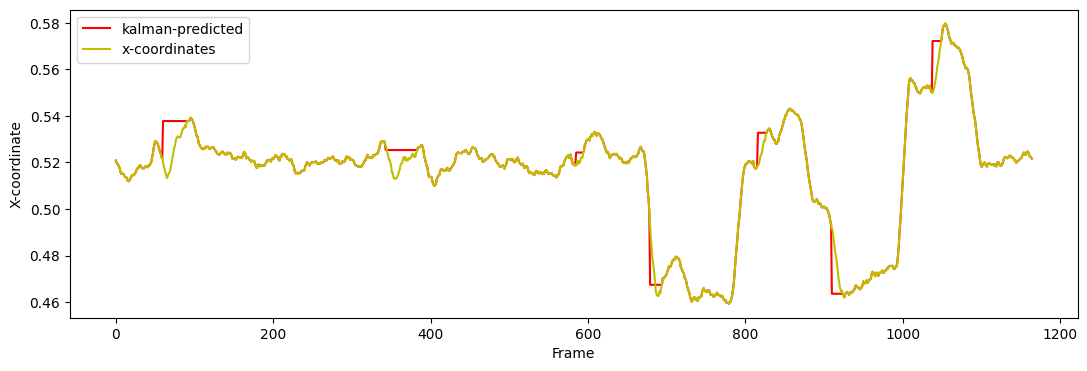

In [28]:
# Actual vs Predicted by Kalman-filter:

plt.figure(figsize=(13,4))
plt.plot(estimated_positions_x, color='r', label='kalman-predicted') 
plt.plot(iris_relative_coords_filtered_array[:,0], color='y', label='x-coordinates') 

plt.xlabel('Frame')
plt.ylabel('X-coordinate')
plt.legend()
plt.show()

# BAD Results: giving linear graph during Blink period 

In [25]:
len(iris_relative_coords_LPF_filtered_array[:, 1])

2460

### Blink Duration Coordinates Prediction: using Cubic Spline Interpolation

In [23]:
from scipy.interpolate import CubicSpline

def CubicSpline_Interpolation(blink_actual_start_frame_index, blink_actual_end_frame_index, iris_relative_coords_LPF_filtered_array):
    iris_relative_coords_interpolated_array = np.copy(iris_relative_coords_LPF_filtered_array)
    
    for t in range (len(blink_actual_end_frame_index)):
        
        # For [X]:
        # (a) Fixed Threshold based classification of Blink:  **(NOT USING - GIVING WRONG POINTS WITH NOISY EAR Values)
        # n_x = np.array([blink_start_frame_index[t]-int((blink_end_frame_index[t] - blink_start_frame_index[t])/4), blink_start_frame_index[t], blink_end_frame_index[t], blink_end_frame_index[t]+(blink_end_frame_index[t] - blink_start_frame_index[t])])
        # x = np.array([iris_relative_coords_filtered_array[blink_start_frame_index[t]-int((blink_end_frame_index[t] - blink_start_frame_index[t])/4), 0], iris_relative_coords_filtered_array[blink_start_frame_index[t], 0], iris_relative_coords_filtered_array[blink_end_frame_index[t], 0], iris_relative_coords_filtered_array[blink_end_frame_index[t]+(blink_end_frame_index[t] - blink_start_frame_index[t]), 0]])
        

        n_x = np.array([blink_actual_start_frame_index[t]-int((blink_actual_end_frame_index[t] - blink_actual_start_frame_index[t])/4), blink_actual_start_frame_index[t], blink_actual_end_frame_index[t], blink_actual_end_frame_index[t]+int((blink_actual_end_frame_index[t] - blink_actual_start_frame_index[t])/4)])
        x = np.array([iris_relative_coords_LPF_filtered_array[blink_actual_start_frame_index[t]-int((blink_actual_end_frame_index[t] - blink_actual_start_frame_index[t])/4), 0], iris_relative_coords_LPF_filtered_array[blink_actual_start_frame_index[t], 0], iris_relative_coords_LPF_filtered_array[blink_actual_end_frame_index[t], 0], iris_relative_coords_LPF_filtered_array[blink_actual_end_frame_index[t]+int((blink_actual_end_frame_index[t] - blink_actual_start_frame_index[t])/4), 0]])
        

        # For [Y]:
        # Derivative based classification of Blink (Most Accurate):
        n_y = np.array([blink_actual_start_frame_index[t]-int((blink_actual_end_frame_index[t] - blink_actual_start_frame_index[t])/4), blink_actual_start_frame_index[t], blink_actual_end_frame_index[t], blink_actual_end_frame_index[t]+int((blink_actual_end_frame_index[t] - blink_actual_start_frame_index[t])/4)])
        y = np.array([iris_relative_coords_LPF_filtered_array[blink_actual_start_frame_index[t]-int((blink_actual_end_frame_index[t] - blink_actual_start_frame_index[t])/4), 1], iris_relative_coords_LPF_filtered_array[blink_actual_start_frame_index[t], 1], iris_relative_coords_LPF_filtered_array[blink_actual_end_frame_index[t], 1], iris_relative_coords_LPF_filtered_array[blink_actual_end_frame_index[t]+int((blink_actual_end_frame_index[t] - blink_actual_start_frame_index[t])/4), 1]])
        
        cs_x = CubicSpline(n_x, x)
        cs_y = CubicSpline(n_y, y)

        for i in range (blink_actual_start_frame_index[t], blink_actual_end_frame_index[t]):
            iris_relative_coords_interpolated_array[i, 0] = cs_x(i)
        
        for i in range (blink_actual_start_frame_index[t], blink_actual_end_frame_index[t]):
            iris_relative_coords_interpolated_array[i, 1] = cs_y(i)
        
    return iris_relative_coords_interpolated_array


iris_relative_coords_interpolated_array = CubicSpline_Interpolation(blink_actual_start_frame_index, blink_actual_end_frame_index, iris_relative_coords_LPF_filtered_array)


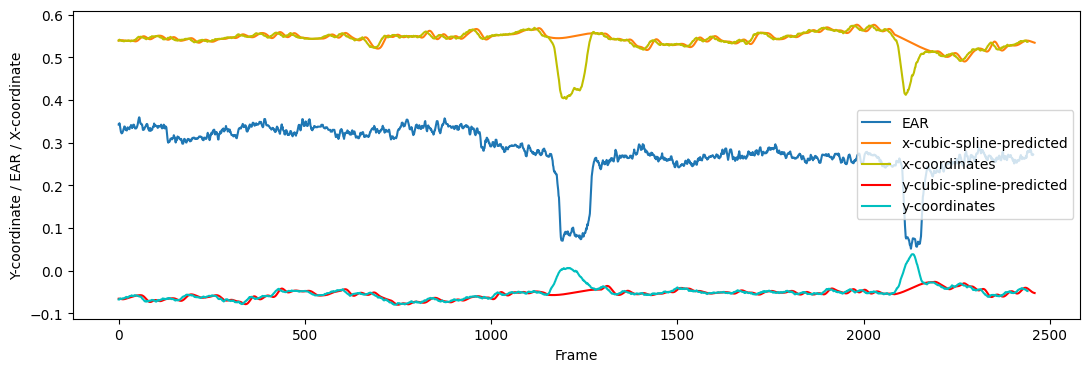

In [24]:
# Actual vs Predicted by Cubic Spline:

plt.figure(figsize=(13,4))
plt.plot(ear_list_smoothed, label='EAR')

plt.plot(iris_relative_coords_interpolated_array[:,0], label='x-cubic-spline-predicted') 
plt.plot(iris_relative_coords_filtered_array[:,0], color='y', label='x-coordinates') 

plt.plot(iris_relative_coords_interpolated_array[:,1], color='r', label='y-cubic-spline-predicted') 
plt.plot(iris_relative_coords_filtered_array[:,1], color='c', label='y-coordinates') 

plt.xlabel('Frame')
plt.ylabel('Y-coordinate / EAR / X-coordinate')
plt.legend()
plt.show()

# GOOD Result for X, But Y still has big noise because of Blink: 

### Saccade and Fixation Estimation

In [25]:
# Canculate Centroid of a Fixation Group: so that nearby consecutive fixations can be merged
def calculate_centroid(fixation_group):
    add_x = 0
    add_y = 0
    for j in range(len(fixation_group)):
        add_x += fixation_group[j][0]
        add_y += fixation_group[j][1]
    centroid_x = add_x/len(fixation_group)
    centroid_y = add_y/len(fixation_group)

    return [centroid_x, centroid_y]

# def calculate_five_point_velocity(five_coordinates):


def estimate_saccades_fixations(iris_coordinates, threshold_x, threshold_y, speed_threshold, elliptic_distance_threshold, max_dispersion_threshold):
    iris_coordinates = iris_coordinates.tolist()

    saccades = []
    fixations = []
    None_list = []

    temp_saccades_list = []
    temp_fix_list = []
    
    is_saccades = False      # Flag to track saccades group

    prev_coords = iris_coordinates[0]
    #prev_time = frame_times[0]
    
    speed_list = []    
    speed_x_list = []           #
    speed_y_list = []           #

    elliptic_distance_list = []

    saccade_index = 0
    fixation_index = 0

    fixation_index_list = []        #
    saccade_index_list = []         #

    merged_fixations = []
    previous_centroid = None
    max_dispersion_distance = max_dispersion_threshold

    last_raw_saccade_grp = []

    saccade_fixation_indicator = []

    for i in range(2, len(iris_coordinates)-2):      #
        curr_coords = iris_coordinates[i]
        #curr_time = frame_times[i]
        
        distance, delta_x, delta_y = calculate_distance(prev_coords, curr_coords)
        # speed = distance / del_time          # del_time = 1/Video_FPS  (Fixed)
        # speed = np.absolute(speed)

        # 5-Point Moving Average Velocity
        '''correct formula is: '''
        speed_x = np.absolute((iris_coordinates[i+1][0]+iris_coordinates[i+2][0]-iris_coordinates[i-2][0]-iris_coordinates[i-1][0]) / (6*del_time))      #
        speed_y = np.absolute((iris_coordinates[i+1][1]+iris_coordinates[i+2][1]-iris_coordinates[i-2][1]-iris_coordinates[i-1][1]) / (6*del_time))      #
        '''but using this (giving better result): '''
        # speed_x = np.absolute((iris_coordinates[i-2][0]+iris_coordinates[i-1][0]+iris_coordinates[i+1][0]+iris_coordinates[i+2][0]) / (6*del_time))      #
        # speed_y = np.absolute((iris_coordinates[i-2][1]+iris_coordinates[i-1][1]+iris_coordinates[i+1][1]+iris_coordinates[i+2][1]) / (6*del_time))      #

        speed = np.absolute(np.sqrt((speed_x**2) *1 + (speed_y**2) *0.3))      # less weightage to y-velocity component (because of higher noise in y)

        speed_list.append(speed)
        speed_x_list.append(speed_x)                    #
        speed_y_list.append(speed_y)                    #

        coords_and_time = curr_coords.copy()
        #coords_and_time.append(curr_time)       # To keep current coords and its time together 
        
        elliptic_distance = (delta_x/threshold_x)**2 + (delta_y/threshold_y)**2

        # capping elliptic_distance value to 50, to be able to visualise the graph properly: can change as per your need
        if elliptic_distance < 50:
            elliptic_distance_list.append(elliptic_distance)
        else:
            elliptic_distance_list.append(50)
        

        # Elliptical Distance Threshold
        if (elliptic_distance) > (1 * elliptic_distance_threshold):
            if speed > speed_threshold:
                # It's a saccades group
        
                # Check if it's a new saccades group
                if not is_saccades:
                    
                    if temp_fix_list:
                        # Transfer previous fixations data to fixations_list:   *(fixations will keep on collected under same index until a saccade group doesn't came, i.e for any 'None' points in between, fixation points after it still be considered under same fixation index)
                        # Merge last 'None' points also to last occuring point type (Fixations)
                        # temp_fix_list.extend(None_list)         #
                        # None_list = []                          #
                        
                        # Merging nearby Fixations
                        centroid = calculate_centroid(temp_fix_list)


                        if previous_centroid is not None:   # from second fixation groups
                            dispersion_distance = math.sqrt((centroid[0] - previous_centroid[0]) ** 2 + (centroid[1] - previous_centroid[1]) ** 2)

                            # merging with previous fixation if previous saccade length is <50ms    **(ADJUST the value 6 to as per your choice)
                            if (len(last_raw_saccade_grp) < 6):  
                                merged_fixations[-1].extend(last_raw_saccade_grp)
                                merged_fixations[-1].extend(temp_fix_list)      # merge with previous fixation group
                                
                                fixation_index_list = fixation_index_list[0:-len(last_raw_saccade_grp)]
                                saccade_fixation_indicator = saccade_fixation_indicator[0:-len(last_raw_saccade_grp)]
                                fixation_index -= 1
                                fixation_index_list.extend([fixation_index] * (len(last_raw_saccade_grp)+len(temp_fix_list)))          #
                                saccade_fixation_indicator.extend([1] * (len(last_raw_saccade_grp)+len(temp_fix_list)))
                                saccade_index_list = saccade_index_list[0:-len(last_raw_saccade_grp)]                 #
                                saccade_index_list.extend([None] * (len(last_raw_saccade_grp)+len(temp_fix_list))) 

                                if len(saccade_fixation_indicator) != (i-2):
                                    print(f'Error at 111111 - len/i-2: ({len(saccade_fixation_indicator)}, {i-2})')
                                print(f'111111- (< disp) _len/last_fix_grp_len/i: ({len(merged_fixations)}, {len(merged_fixations[-1])}, {i})')

                                if len(last_raw_saccade_grp)>=6:        # for last_raw_saccade_grp of len <5, they were NOT added to the saccade list so no need to pop it
                                    saccades.pop(-1)    # remove intermediate saccade group
                                    saccade_index -= 1
                                
                            else:
                                
                                merged_fixations.append(temp_fix_list)

                                fixation_index += 1                                         #
                                len_f = len(merged_fixations[-1])                                  #
                                fixation_index_list.extend([fixation_index]*len_f)          #
                                saccade_index_list.extend([None]*len_f)                     #

                                saccade_fixation_indicator.extend([1]*len_f)

                                if len(saccade_fixation_indicator) != (i-2):
                                    print(f'Error at 111112 - len/i-2: ({len(saccade_fixation_indicator)}, {i-2})')
                                print(f'111112- (> disp) _len/last_fix_grp_len/2nd_last_fix_grp_len/i: ({len(merged_fixations)}, {len(merged_fixations[-1])}, {len(merged_fixations[-2])}, {i})')


                                if len(merged_fixations[-2]) <= int(0.120 * video_fps):    # 0.120 * video_fps      **(ADJUST the value 0.120 to as per your choice)
                                    # Remove the '2nd last' Fixation Group if (Duration is < 150 ms)** and **MERGE 'IT and ITS NEXT SACCADE' WITH Previous Saccade
                                    # fixation_index_list[-len(merged_fixations[-1])-len(last_raw_saccade_grp)-len(merged_fixations[-2]) : -len(merged_fixations[-1])-len(last_raw_saccade_grp)] = [None]*len(merged_fixations[-2])
                                    # saccade_fixation_indicator[-len(merged_fixations[-1])-len(last_raw_saccade_grp)-len(merged_fixations[-2]) : -len(merged_fixations[-1])] = [2]*(len(merged_fixations[-2]) + len(last_raw_saccade_grp))
                                    

                                    # saccades[-2].extend(merged_fixations[-2])          # Merging with 2nd last saccade                   
                                    # saccades[-2].extend(saccades[-1])
                                    # saccades.pop(-1)
                                    # saccade_index -= 1

                                    # merged_fixations.pop(-2)
                                    # fixation_index -= 1

                                    # saccade_index_list[-len(merged_fixations[-1])-len(last_raw_saccade_grp)-len(merged_fixations[-2]) : -len(merged_fixations[-1])] = [saccade_index-1]*len(merged_fixations[-2])


                                    ### Remove the '2nd last' Fixation Group if (Duration is < 150 ms)** and make them **"NONE":
                                    fixation_index_list[-len(merged_fixations[-1])-len(last_raw_saccade_grp)-len(merged_fixations[-2]) : -len(merged_fixations[-1])-len(last_raw_saccade_grp)] = [None]*len(merged_fixations[-2])
                                    saccade_fixation_indicator[-len(merged_fixations[-1])-len(last_raw_saccade_grp)-len(merged_fixations[-2]) : -len(merged_fixations[-1])-len(last_raw_saccade_grp)] = [0]*len(merged_fixations[-2])

                                    merged_fixations.pop(-2)
                                    fixation_index -= 1

                                    if len(saccade_fixation_indicator) != (i-2):
                                        print(f'Error at 1111121 - len/i-2: ({len(saccade_fixation_indicator)}, {i-2})')
                                    print(f'1111121- (>disp) but (2nd_last_fix_len<150ms) _len/last_fix_grp_len/i: ({len(merged_fixations)}, {len(merged_fixations[-1])}, {i})')
                                
                                    
                        else:
                            # first fixation group
                            merged_fixations.append(temp_fix_list)

                            fixation_index += 1                                         #
                            len_f = len(merged_fixations[-1])                                  #
                            fixation_index_list.extend([fixation_index]*len_f)          #
                            saccade_index_list.extend([None]*len_f)                     #

                            saccade_fixation_indicator.extend([1]*len_f)

                            if len(saccade_fixation_indicator) != (i-2):
                                print(f'Error at 11112 - len/i-2: ({len(saccade_fixation_indicator)}, {i-2})')
                            print(f'11112- (first fix_grp) _len/last_fix_grp_len/i: ({len(merged_fixations)}, {len(merged_fixations[-1])}, {i})')

                        previous_centroid = centroid


                        temp_fix_list = []

                    # Reset temporary saccades list
                    temp_saccades_list = []
        
                # Add current saccades group to temporary saccades list
                # First empty the 'None' list:
                if None_list:
                    saccade_index_list.extend([None]* len(None_list))           
                    fixation_index_list.extend([None]* len(None_list))         
                    saccade_fixation_indicator.extend([0]* len(None_list))      # to colour highlight saccade-fixation in plot (this case: none)
                    None_list = []
                

                coords_and_time.append(speed)            # add speed information also 
                temp_saccades_list.append(coords_and_time)

                print(f'saccade_point: i={i}')
                
                is_saccades = True
            
            else:  # NONE: Neither Saccade nor Fixation

                coords_and_time.append(speed)           #
                None_list.append(coords_and_time)       #

                # saccade_index_list.append([None])           
                # fixation_index_list.append([None])          

                # saccade_fixation_indicator.extend([0])      # to colour highlight saccade-fixation in plot (this case: none)

                if len(saccade_fixation_indicator) != (i-2):
                    print(f'Error at 12 - len/i-2: ({len(saccade_fixation_indicator)}, {i-2})')
                print(f'12- len/i: ({len(saccade_fixation_indicator)}, {i})')


        else:
                # It's a fixation group
        
                # Check if it's the end of a saccades group
                if is_saccades:

                    # Merge last 'None' points also to last occuring point type (Fixations)
                    # temp_saccades_list.extend(None_list)        #
                    # None_list = []                              #   

                    len_s = len(temp_saccades_list)
                    # Transfer previous saccades data to saccades_list
                    if temp_saccades_list and len_s >= 6:  # 9    # Min saccade length >= 50 ms      **(ADJUST the value 6 to as per your choice)

                        if  (fixation_index > 0) and (saccade_index > 1) and (len(merged_fixations[-1]) < 7): # 8   # If last fixation group is very small (<8) then merge it and current saccade with last saccade group
                            saccades[-1].extend(merged_fixations[-1])
                            saccades[-1].extend(temp_saccades_list)      # merge with previous saccade group
                            
                            saccade_index_list = saccade_index_list[0:-len(merged_fixations[-1])]
                            saccade_fixation_indicator = saccade_fixation_indicator[0:-len(merged_fixations[-1])]
                            # saccade_index -= 1
                            saccade_index_list.extend([saccade_index-1] * (len(merged_fixations[-1])+len(temp_saccades_list)))          #
                            saccade_fixation_indicator.extend([2] * (len(merged_fixations[-1])+len(temp_saccades_list)))
                            fixation_index_list = fixation_index_list[0:-len(merged_fixations[-1])]                 #
                            fixation_index_list.extend([None] * (len(merged_fixations[-1])+len(temp_saccades_list)))

                            merged_fixations.pop(-1)    # remove the points (last fixation grp) from the fixation list
                            fixation_index -= 1 

                            print(f'2111- (saccade_grp > 50ms) & (len_last_fix < 5) _len/last_saccade_grp_len/i: ({len(saccades)}, {len(saccades[-1])}, {i})')

                        else:       # New saccade group
                            saccades.append(temp_saccades_list)
                            
                            saccade_index += 1                                         #
                            saccade_index_list.extend([saccade_index]*len_s)           #
                            fixation_index_list.extend([None]*len_s)                   #

                            saccade_fixation_indicator.extend([2]*len_s)        # to colour highlight saccades in plot 

                            last_raw_saccade_grp = temp_saccades_list
                            temp_saccades_list = []

                            if len(saccade_fixation_indicator) != (i-2):
                                print(f'Error at 211 - len/i-2: ({len(saccade_fixation_indicator)}, {i-2})')
                            print(f'2112- (saccade_grp > 50ms) & (len_last_fix > 5) _len/last_saccade_grp_len/i: ({len(saccades)}, {len(saccades[-1])}, {i})')


                    # If current saccade group length is < 6, Discard them
                    elif temp_saccades_list and len_s < 6:  # 9         **(ADJUST the value 6 to as per your choice)
                        last_raw_saccade_grp = temp_saccades_list
                        saccade_index_list.extend([None]*len_s)           #
                        fixation_index_list.extend([None]*len_s)                   #

                        saccade_fixation_indicator.extend([0]*len_s)        # to colour highlight saccades in plot   
                        temp_saccades_list = [] 

                        if len(saccade_fixation_indicator) != (i-2):
                            print(f'Error at 212 - len/i-2: ({len(saccade_fixation_indicator)}, {i-2})')
                        print(f'212- (saccade_grp < 50 ms) _len/i: ({len(saccades)}, {i})')    
                
                    # Reset is_saccades flag
                    is_saccades = False
                
                # Add current fixations group to temporary fixations list
                # if 'None' points present: Add them to Fixations
                if None_list:
                    temp_fix_list.extend(None_list)
                    None_list = []
                
                coords_and_time.append(speed)            # add speed information also
                temp_fix_list.append(coords_and_time)

                print(f'fixation_point: i={i}')
        
        prev_coords = curr_coords
        #prev_time = curr_time

    # ----------------------------------- LOOP ENDS ---------------------------------------------------------------------
        
        
    # ** For any remaining saccades or fixation points Not added to their respective Lists because of for-loop iteration got over:
    # If they are saccades:
    if is_saccades:
        # Merge last 'None' points also to last occuring point type (Fixations)
        # temp_saccades_list.extend(None_list)        #
        # None_list = []                              #

        len_s = len(temp_saccades_list)
        # Transfer previous saccades data to saccades_list
        if temp_saccades_list and len_s>= 5:      # Min saccade length >= 50 ms **
            saccades.append(temp_saccades_list)
            
            saccade_index += 1                                         #
            saccade_index_list.extend([saccade_index]*len_s)           #
            fixation_index_list.extend([None]*len_s)                   #

            saccade_fixation_indicator.extend([2]*len_s)        # to colour highlight saccades in plot 

            last_raw_saccade_grp = temp_saccades_list
            temp_saccades_list = []

            print(f'outside loop - saccade (len>5) - len: {len(saccade_fixation_indicator)}')

        
        elif temp_saccades_list and len_s < 5:
            last_raw_saccade_grp = temp_saccades_list
            saccade_index_list.extend([None]*len_s)           #
            fixation_index_list.extend([None]*len_s)                   #

            saccade_fixation_indicator.extend([0]*len_s)        # to colour highlight saccades in plot   
            temp_saccades_list = [] 

            print(f'outside loop - saccade (len<5) - len: {len(saccade_fixation_indicator)}')    
    
    
    # If they are Fixations:
    if not is_saccades:
        # Transfer previous fixations data to fixations_list
        if temp_fix_list:

            # Merge last 'None' points also to last occuring point type (Fixations)
            # temp_fix_list.extend(None_list)     #
            # None_list = []                      #
            
            # Merging nearby Fixations
            centroid = calculate_centroid(temp_fix_list)

            if previous_centroid is not None:
                dispersion_distance = math.sqrt((centroid[0] - previous_centroid[0]) ** 2 + (centroid[1] - previous_centroid[1]) ** 2)

                if (len(last_raw_saccade_grp)<5):  # merging with previous fixation if previous saccade length is <50ms
                    merged_fixations[-1].extend(last_raw_saccade_grp)
                    merged_fixations[-1].extend(temp_fix_list)      # merge with previous fixation group
                    
                    fixation_index_list = fixation_index_list[0:-len(last_raw_saccade_grp)]
                    saccade_fixation_indicator = saccade_fixation_indicator[0:-len(last_raw_saccade_grp)]
                    fixation_index -= 1
                    fixation_index_list.extend([fixation_index] * (len(last_raw_saccade_grp)+len(temp_fix_list)))          #
                    saccade_fixation_indicator.extend([1] * (len(last_raw_saccade_grp)+len(temp_fix_list)))
                    saccade_index_list = saccade_index_list[0:-len(last_raw_saccade_grp)]                 #
                    saccade_index_list.extend([None] * (len(last_raw_saccade_grp)+len(temp_fix_list))) 

                    if len(saccade_fixation_indicator) != (i-2):
                        print(f'Error at 111111 - len/i-2: ({len(saccade_fixation_indicator)}, {i-2})')
                    print(f'111111- (< disp) _len/last_fix_grp_len/i: ({len(merged_fixations)}, {len(merged_fixations[-1])}, {i})')

                    if len(last_raw_saccade_grp)>=5:        # for last_raw_saccade_grp of len <5, they were NOT added to the saccade list so no need to pop it
                        saccades.pop(-1)    # remove intermediate saccade group
                        saccade_index -= 1
                    
                else:
                    
                    merged_fixations.append(temp_fix_list)

                    fixation_index += 1                                         #
                    len_f = len(merged_fixations[-1])                                  #
                    fixation_index_list.extend([fixation_index]*len_f)          #
                    saccade_index_list.extend([None]*len_f)                     #

                    saccade_fixation_indicator.extend([1]*len_f)

                    if len(saccade_fixation_indicator) != (i-2):
                        print(f'Error at 111112 - len/i-2: ({len(saccade_fixation_indicator)}, {i-2})')
                    print(f'111112- (> disp) _len/last_fix_grp_len/2nd_last_fix_grp_len/i: ({len(merged_fixations)}, {len(merged_fixations[-1])}, {len(merged_fixations[-2])}, {i})')


                    if len(merged_fixations[-2]) <= int(0.120 * video_fps) and fixation_index > 1:    
                        
                        # Remove the '2nd last' Fixation Group if (Duration is < 150 ms)** and make them **"NONE":
                        fixation_index_list[-len(merged_fixations[-1])-len(last_raw_saccade_grp)-len(merged_fixations[-2]) : -len(merged_fixations[-1])-len(last_raw_saccade_grp)] = [None]*len(merged_fixations[-2])
                        saccade_fixation_indicator[-len(merged_fixations[-1])-len(last_raw_saccade_grp)-len(merged_fixations[-2]) : -len(merged_fixations[-1])-len(last_raw_saccade_grp)] = [0]*len(merged_fixations[-2])

                        merged_fixations.pop(-2)
                        fixation_index -= 1

                        if len(saccade_fixation_indicator) != (i-2):
                            print(f'Error at 1111121 - len/i-2: ({len(saccade_fixation_indicator)}, {i-2})')
                        print(f'1111121- (>disp) but (2nd_last_fix_len<150ms) _len/last_fix_grp_len/i: ({len(merged_fixations)}, {len(merged_fixations[-1])}, {i})')


    
    return saccades, merged_fixations, saccade_index_list, fixation_index_list, speed_x_list, speed_y_list, saccade_fixation_indicator, elliptic_distance_list, speed_list

In [29]:
speed_threshold = np.sqrt((threshold_x)**2 + (threshold_y)**2)*30 * 3       # **(ADJUST the MULTIPLIER value 30* 3 to as per your choice)
elliptic_distance_threshold = 2         # **(ADJUST the value 3 to as per your choice)
max_dispersion_threshold = 0.01         # **(ADJUST the value 0.01 to as per your choice)

saccades, fixations, saccade_index_list, fixation_index_list, speed_x_list, speed_y_list, saccade_fixation_indicator, elliptic_distance_list, speed_list = estimate_saccades_fixations(iris_relative_coords_interpolated_array[:,:2], threshold_x, threshold_y, speed_threshold, elliptic_distance_threshold, max_dispersion_threshold)
# **Note that 'saccade_in
# dex_list', 'fixation_index_list', 'speed_x_list', 'speed_y_list' has NO VALUES for two-positions from start and two-positions from end



# centroid_diff_list = []         #
# for i in range(1, len(fixations)):     #
#     centroid_diff = list(np.subtract(np.array(calculate_centroid(fixations[i])), np.array(calculate_centroid(fixations[i-1]))))
#     centroid_diff_list.append(centroid_diff)


# plt.figure(figsize=(10,6))
# plt.ylim(0,10)
# plt.stem(speed_list, markerfmt=" ", basefmt="0 ")
# plt.xlabel('time or frame')
# plt.ylabel('speed')
# plt.plot([0, len(speed_list)], [speed_threshold, speed_threshold], color='orange')
# plt.plot(elliptic_distance_list, color='brown' )
# plt.legend(['Speed Threshold', 'Elliptical Distance', 'Speed'])

# print('Saccades: ', saccades)
# print(f'No. of Fixations: {len(fixations)}, Fixations: {fixations}')
# print(f'No. of Merged Fixatioms: {len(merged_fixations)}, Merged Fixations: {merged_fixations}')

# print('Adjacent Centroid Differences in Fixations: ', centroid_diff_list)    #




saccades_csv_filename = "saccades.csv"  
with open(saccades_csv_filename, "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerows(saccades)

fixations_csv_filename = "fixations.csv"  
with open(fixations_csv_filename, "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerows(fixations)


# Eye Data CSV File             ##
eye_data_csv_fields = ["GAZE_X", "GAZE_Y", "FIXATION_INDEX", "SACCADE_INDEX", "VELOCITY_X", "VELOCITY_Y", "EAR", "EAR_SMOOTHED", "BLINK", "RESOLUTION_X", "RESOLUTION_Y"]
eye_data_csv_rows = list(zip(iris_relative_coords_interpolated_array[2:-2, 0], iris_relative_coords_interpolated_array[2:-2, 1], fixation_index_list, saccade_index_list, speed_x_list, speed_y_list, ear_list[2:-2], ear_list_smoothed[2:-2]))
eye_data_csv_filename = "eye_data.csv"
with open(eye_data_csv_filename, "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(eye_data_csv_fields)
    writer.writerows(eye_data_csv_rows)

fixation_point: i=2
fixation_point: i=3
fixation_point: i=4
fixation_point: i=5
fixation_point: i=6
fixation_point: i=7
fixation_point: i=8
fixation_point: i=9
fixation_point: i=10
fixation_point: i=11
fixation_point: i=12
fixation_point: i=13
fixation_point: i=14
fixation_point: i=15
fixation_point: i=16
fixation_point: i=17
fixation_point: i=18
fixation_point: i=19
fixation_point: i=20
fixation_point: i=21
fixation_point: i=22
fixation_point: i=23
fixation_point: i=24
fixation_point: i=25
fixation_point: i=26
fixation_point: i=27
fixation_point: i=28
fixation_point: i=29
fixation_point: i=30
fixation_point: i=31
fixation_point: i=32
fixation_point: i=33
fixation_point: i=34
fixation_point: i=35
fixation_point: i=36
fixation_point: i=37
fixation_point: i=38
fixation_point: i=39
fixation_point: i=40
fixation_point: i=41
fixation_point: i=42
fixation_point: i=43
fixation_point: i=44
fixation_point: i=45
fixation_point: i=46
fixation_point: i=47
fixation_point: i=48
fixation_point: i=49


In [30]:
print(len(saccade_fixation_indicator))
print(len(iris_relative_coords_LPF_filtered_array[2:-2]))
# print(iris_relative_coords_interpolated_array[1797])            # [ 0.48867724 -0.04353022]
print(len(speed_x_list))

# speed_list = np.sqrt(np.square(speed_x_list) + np.square(speed_y_list))
print(f'speed threshold = {speed_threshold}')   # 0.019208600280596674
# elliptic_distance_list


2456
2456
2456
speed threshold = 0.05691196503898778


### Saccade - Fixation PLOT

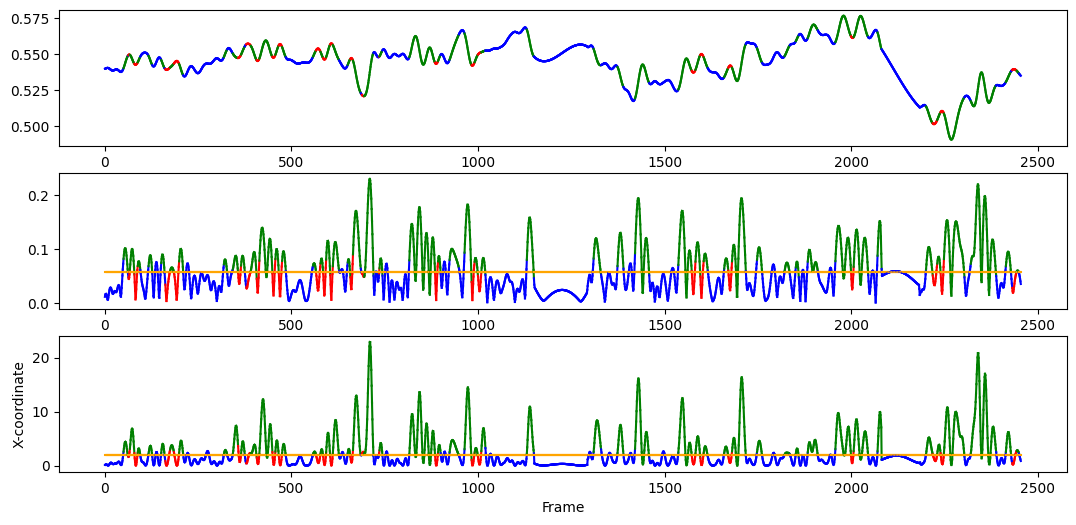

In [31]:
data = pd.DataFrame({'group': pd.Categorical(['a', 'b', 'b', 'a', 'a', 'a', 'b', 'b'])})
colours = {0: 'red', 1:'blue', 2:'green'}
labels = {0: 'None', 1:'Fixation', 2:'Saccade'}

# from scipy.signal import savgol_filter
# speed_savgol_x = savgol_filter(iris_relative_coords_interpolated_array[:,0], 5, 2, deriv=1 , mode='nearest')
# speed_savgol_y = savgol_filter(iris_relative_coords_interpolated_array[:,1], 5, 2, deriv=1 , mode='nearest')

# speed_savgol = np.sqrt(np.square(speed_savgol_x)*1 + np.square(speed_savgol_y)*0.2)


# plt.figure(figsize=(13,4))
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(13,6))

for i in range(0, 0 + len(iris_relative_coords_interpolated_array[2:-2,0])-1):     # [2:-2,0]
    # plt.plot([i, i+1],[iris_relative_coords_interpolated_array[2+i,0], iris_relative_coords_interpolated_array[2+i+1,0]], color=colours[saccade_fixation_indicator[i]])
    
    ax1.plot([i, i+1],[iris_relative_coords_interpolated_array[2+i, 0], iris_relative_coords_interpolated_array[2+i+1, 0]], color=colours[saccade_fixation_indicator[i]])
    ax2.plot([i, i+1],[speed_list[i], speed_list[i+1]], color=colours[saccade_fixation_indicator[i]])
    ax2.plot([i, i+1], [speed_threshold, speed_threshold], color='orange')
    ax3.plot([i, i+1],[elliptic_distance_list[i], elliptic_distance_list[i+1]], color=colours[saccade_fixation_indicator[i]])
    ax3.plot([i, i+1], [elliptic_distance_threshold, elliptic_distance_threshold], color='orange')
    


plt.xlabel('Frame')
plt.ylabel('X-coordinate')
plt.show()



### PART 2: Eye Features for Facial Action Unit Intensity Activation

### Face Action Unit Intensity and Eye Coord Plots

Text(0, 0.5, 'AU 26')

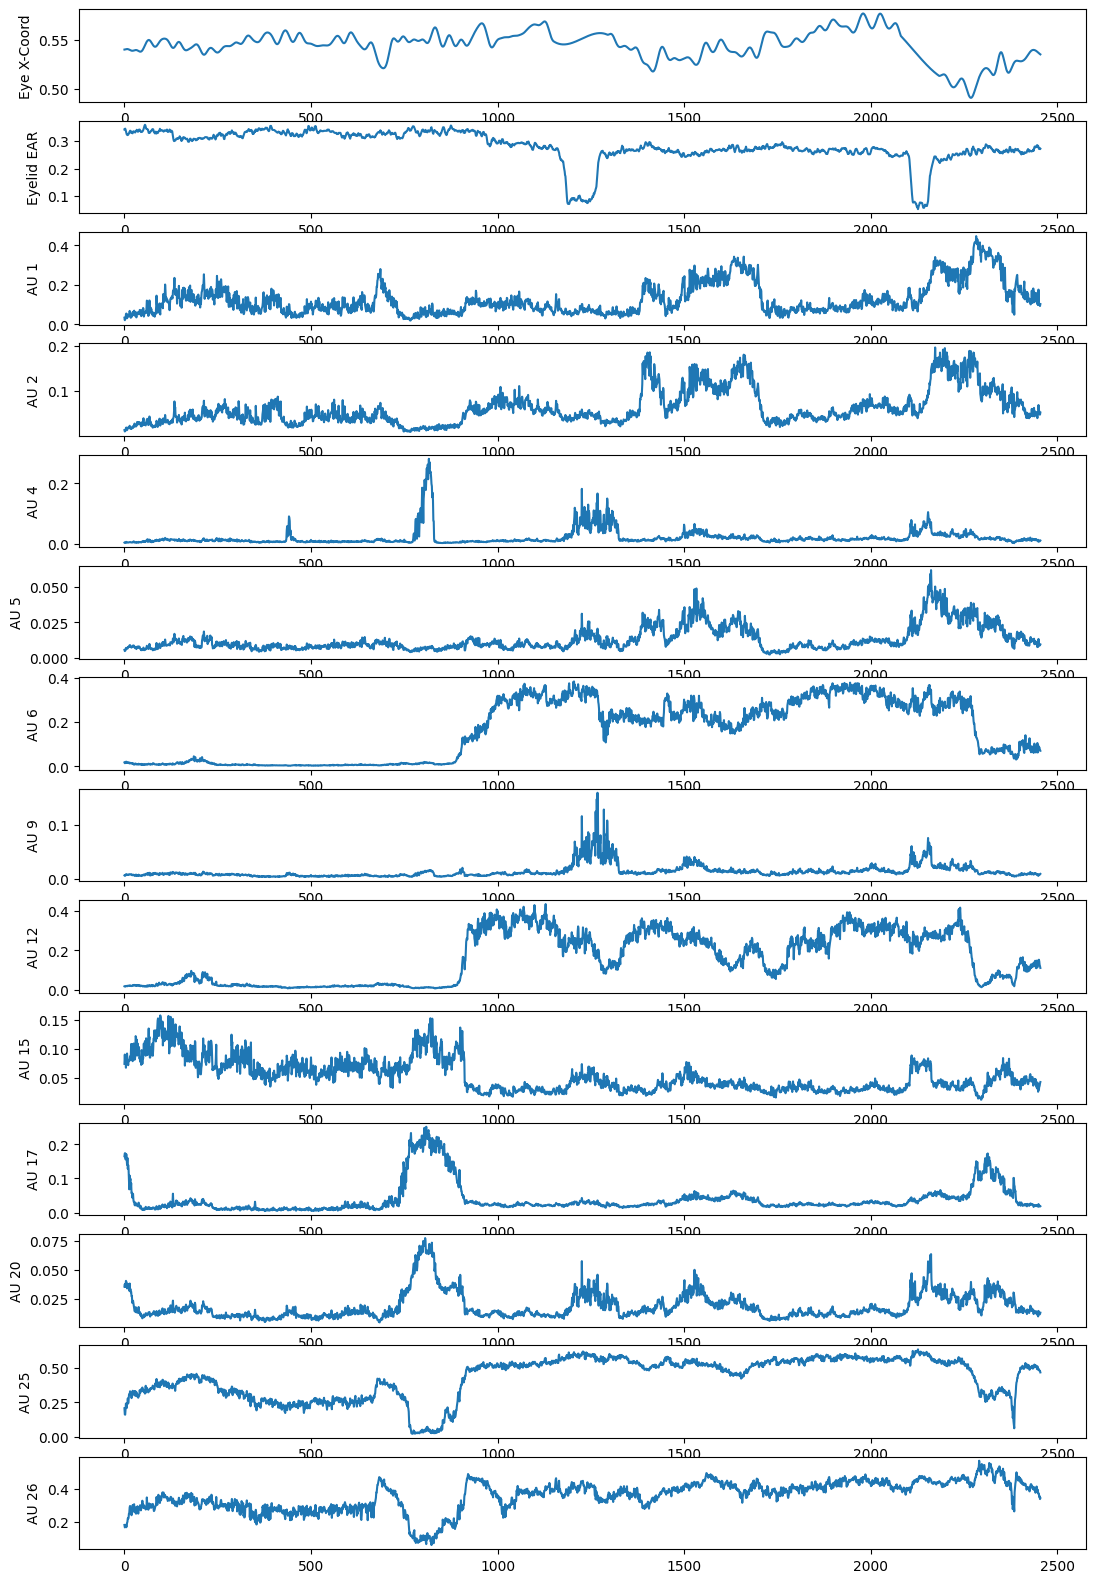

In [32]:
fig, axes = plt.subplots(14, figsize=(13,20))

df = pd.read_csv('Parth_5_pred_list.csv').iloc[2:-2, 1:]
action_units_series = df.to_numpy()

axes[0].plot(iris_relative_coords_interpolated_array[2:-2,0])
axes[0].set_ylabel('Eye X-Coord')
axes[1].plot(ear_list_smoothed)
axes[1].set_ylabel('Eyelid EAR')
axes[2].plot(action_units_series[:, 0])
axes[2].set_ylabel('AU 1')
axes[3].plot(action_units_series[:, 1])
axes[3].set_ylabel('AU 2')
axes[4].plot(action_units_series[:, 2])
axes[4].set_ylabel('AU 4')
axes[5].plot(action_units_series[:, 3])
axes[5].set_ylabel('AU 5')
axes[6].plot(action_units_series[:, 4])
axes[6].set_ylabel('AU 6')
axes[7].plot(action_units_series[:, 5])
axes[7].set_ylabel('AU 9')
axes[8].plot(action_units_series[:, 6])
axes[8].set_ylabel('AU 12')
axes[9].plot(action_units_series[:, 7])
axes[9].set_ylabel('AU 15')
axes[10].plot(action_units_series[:, 8])
axes[10].set_ylabel('AU 17')
axes[11].plot(action_units_series[:,9])
axes[11].set_ylabel('AU 20')
axes[12].plot(action_units_series[:, 10])
axes[12].set_ylabel('AU 25')
axes[13].plot(action_units_series[:, 11])
axes[13].set_ylabel('AU 26')


Text(0, 0.5, 'AU 26')

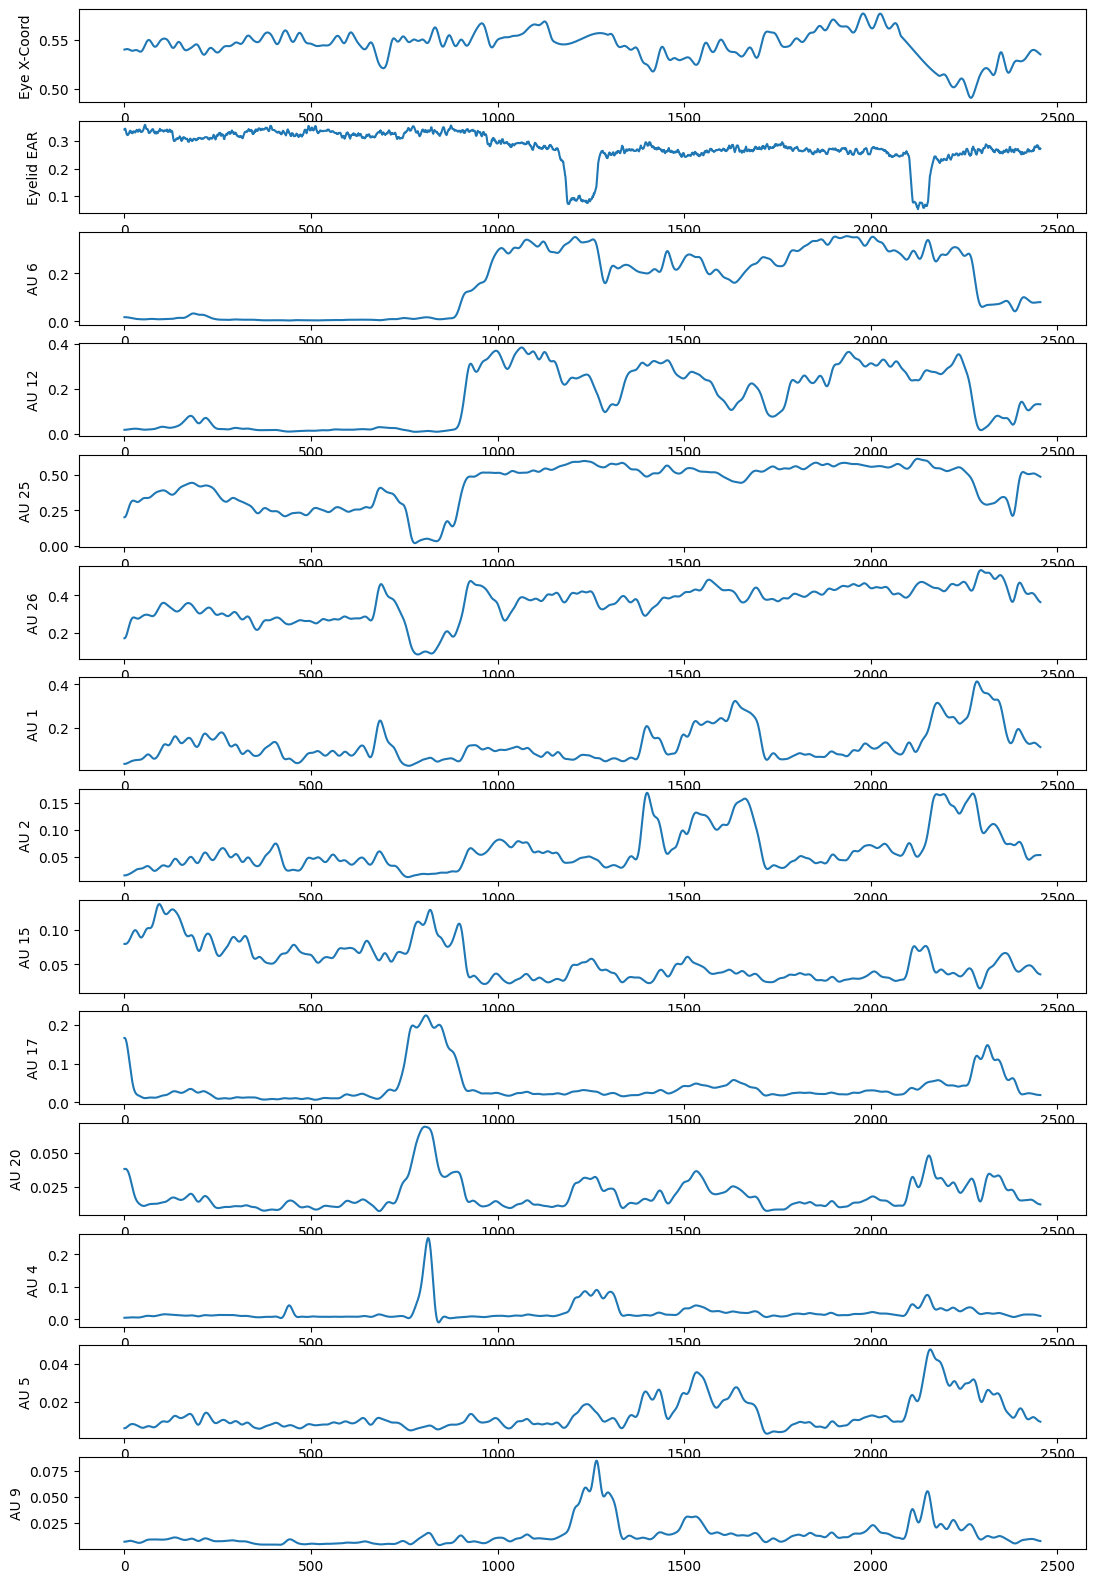

In [33]:
# FILTERED AU Intensity Values:

fig, axes = plt.subplots(14, figsize=(13,20))

# df = pd.read_csv('Parth_5_pred_list.csv').iloc[2:-2, 1:]
# action_units_series = df.to_numpy()

action_units_series_filtered = np.zeros_like(action_units_series)

lpf_order = 4           
lpf_cutoff_freq = 4     # in (Hz)
sampling_rate = video_fps
for i in range(0,12):
    action_units_series_filtered[:,i] = lowpass_filter(action_units_series[:,i], lpf_order, lpf_cutoff_freq, sampling_rate)

# 6, 12, 25, 26, 1, 2, 15, 17, 20, 4, 5, 9
axes[0].plot(iris_relative_coords_interpolated_array[2:-2,0])
axes[0].set_ylabel('Eye X-Coord')
axes[1].plot(ear_list_smoothed)
axes[1].set_ylabel('Eyelid EAR')
axes[6].plot(action_units_series_filtered[:, 0])
axes[6].set_ylabel('AU 1')
axes[7].plot(action_units_series_filtered[:, 1])
axes[7].set_ylabel('AU 2')
axes[11].plot(action_units_series_filtered[:, 2])
axes[11].set_ylabel('AU 4')
axes[12].plot(action_units_series_filtered[:, 3])
axes[12].set_ylabel('AU 5')
axes[2].plot(action_units_series_filtered[:, 4])
axes[2].set_ylabel('AU 6')
axes[13].plot(action_units_series_filtered[:, 5])
axes[13].set_ylabel('AU 9')
axes[3].plot(action_units_series_filtered[:, 6])
axes[3].set_ylabel('AU 12')
axes[8].plot(action_units_series_filtered[:, 7])
axes[8].set_ylabel('AU 15')
axes[9].plot(action_units_series_filtered[:, 8])
axes[9].set_ylabel('AU 17')
axes[10].plot(action_units_series_filtered[:,9])
axes[10].set_ylabel('AU 20')
axes[4].plot(action_units_series_filtered[:, 10])
axes[4].set_ylabel('AU 25')
axes[5].plot(action_units_series_filtered[:, 11])
axes[5].set_ylabel('AU 26')


### Estimating Relation between Action Units (Micro-Expressions) and Saccade-Fixations

au max min list: [[ 0.41331483  0.16858878  0.25040264  0.04791688  0.35575901  0.08461888
   0.38321445  0.13713172  0.22478978  0.06960962  0.61475743  0.53515011]
 [ 0.028355    0.0126423  -0.00916027  0.00292413  0.00338578  0.00412713
   0.01044294  0.01527981  0.00680416  0.00699233  0.01725022  0.08566481]]
Emotion activate ranges: [[897, 2285, 2319, 2379, 2385, 2386, 2389, 2455], [435, 450, 789, 834, 1194, 1326, 1498, 1563, 2102, 2174, 2180, 2196, 2212, 2230, 2252, 2278], [435, 450, 778, 834, 1194, 1326, 1498, 1563, 2102, 2174, 2180, 2196, 2212, 2230, 2252, 2278], []]


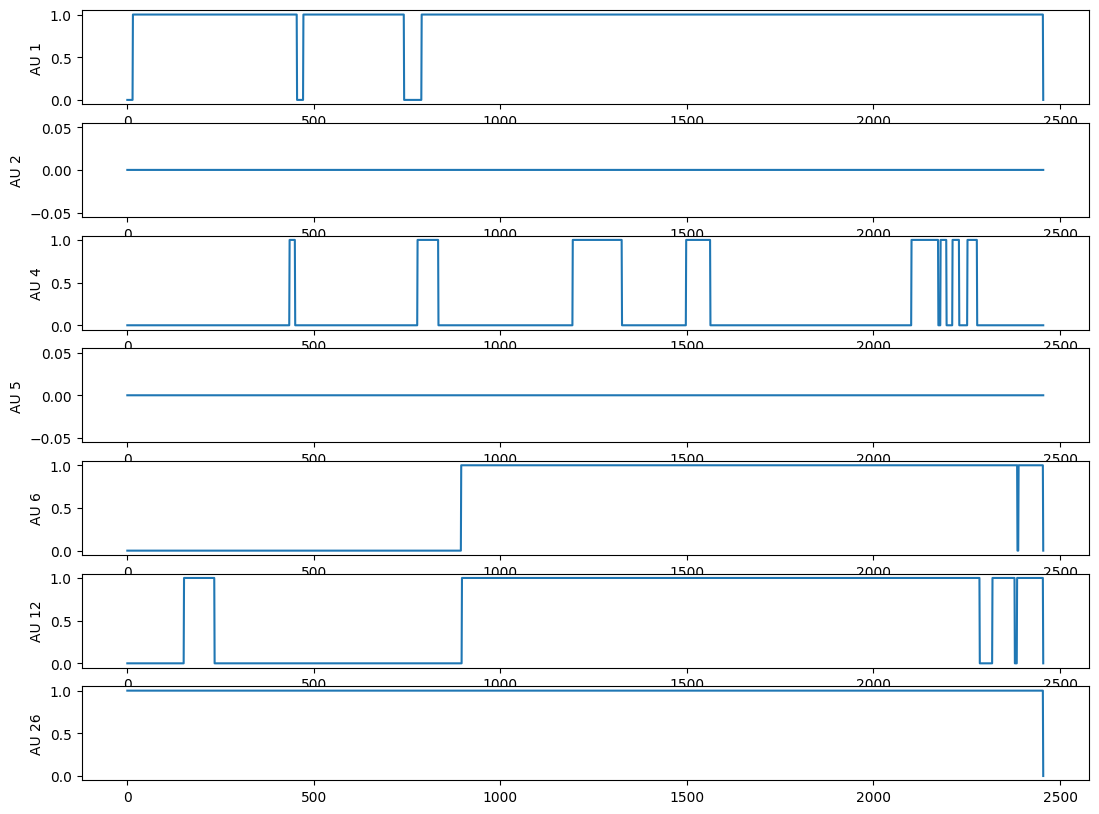

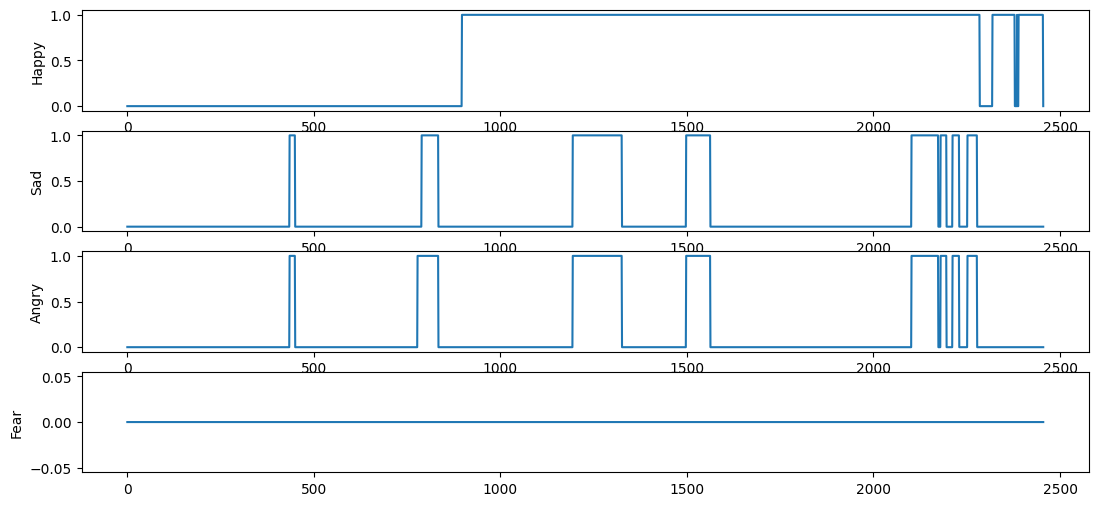

In [36]:
# AUs: 1, 2, 4, 5, 6, 9, 12, 15, 17, 20, 25, 26
# Relavant AUs: 1, 2, 4, 5, 6, 12, 26  -> index: 0,1,2,3,4,6,11


au_max_min_array = np.zeros((2, 12))

for i in range(0, 12):
    au_max_min_array[0, i] = np.max(action_units_series_filtered[:, i])
    au_max_min_array[1, i] = np.min(action_units_series_filtered[:, i])

print(f'au max min list: {au_max_min_array}')

au_activate_list = [[], [], [], [], [], [], [], [], [], [], [], []]  # 12 sub-lists for each Action Unit
time_len = len(action_units_series_filtered[:, 0])

emotion_au_map = {'happy':[4, 6], 'sad':[0, 2], 'angry':[2], 'fear': [0, 1, 2, 3, 11]}

for i in [0,1,2,3,4,6,11]:
    if au_max_min_array[0, i] >= 0.2:       # Considering only those Action Units whose Max intensity value is > 0.2    **(PARAMETER: Adjustable)
        au_start = False
        au_end = False

        # Storing indices where AU intensity value is more than a certain Threshold
        for j in range(time_len):
            if (action_units_series_filtered[j, i] >= 0.12*(au_max_min_array[0, i]-au_max_min_array[1, i])) and au_start==False:     # Threshold = 12% of (Max-Min) AU Intensity    **(PARAMETER: Adjustable)
                au_activate_list[i].append(j)
                au_start = True
                au_end = True
            
            if (action_units_series_filtered[j, i] < 0.12*(au_max_min_array[0, i]-au_max_min_array[1, i])) and au_end==True:
                au_activate_list[i].append(j)
                au_start = False
                au_end = False
            
            if (j==time_len-1) and (au_end==True):      # if reached last index and values has not fell below threshold: take the last index as end index
                au_activate_list[i].append(j)

        
au_activate_switch_series = np.zeros((7, time_len))

# Creating a time series with value = 1 for the time duration of activation of the AU, rest value = 0
for (index, val) in enumerate([0,1,2,3,4,6,11]):            # AUs: 1, 2, 4, 5, 6, 12, 26
    if au_max_min_array[0, val] >= 0.2:
        for i in range(0, len(au_activate_list[val]), 2):
            # print(f'au_index {val}; i={i}')
            # print(f'range: {au_activate_list[val][i]} - {au_activate_list[val][i+1]}')
            for j in range(au_activate_list[val][i], au_activate_list[val][i+1]):
                au_activate_switch_series[index, j] = 1

fig, axes = plt.subplots(7, figsize=(13,10))

axes[0].plot(au_activate_switch_series[0])
axes[0].set_ylabel('AU 1')
axes[1].plot(au_activate_switch_series[1])
axes[1].set_ylabel('AU 2')
axes[2].plot(au_activate_switch_series[2])
axes[2].set_ylabel('AU 4')
axes[3].plot(au_activate_switch_series[3])
axes[3].set_ylabel('AU 5')
axes[4].plot(au_activate_switch_series[4])
axes[4].set_ylabel('AU 6')
axes[5].plot(au_activate_switch_series[5])
axes[5].set_ylabel('AU 12')
axes[6].plot(au_activate_switch_series[6])
axes[6].set_ylabel('AU 26')

# Total AUs: 1, 2, 4, 5, 6, 9, 12, 15, 17, 20, 25, 26
# Relavant AUs: 1, 2, 4, 5, 6, 12, 26  -> index: 0,1,2,3,4,6,11
emotion_au_map = {'happy':[4, 6], 'sad':[0, 2], 'angry':[2], 'fear': [0, 1, 2, 3, 11]}

# Emotion activation series: checking activation of corresponding AUs (as per Facial Action Coding System)
happy_series = au_activate_switch_series[4] * au_activate_switch_series[5]
sad_series = au_activate_switch_series[0] * au_activate_switch_series[2]
angry_series = au_activate_switch_series[2]
fear_series = au_activate_switch_series[0] * au_activate_switch_series[1] * au_activate_switch_series[2] * au_activate_switch_series[6] #* au_activate_switch_series[3]


fig, axes = plt.subplots(4, figsize=(13,6))
axes[0].plot(happy_series)
axes[0].set_ylabel('Happy')
axes[1].plot(sad_series)
axes[1].set_ylabel('Sad')
axes[2].plot(angry_series)
axes[2].set_ylabel('Angry')
axes[3].plot(fear_series)
axes[3].set_ylabel('Fear')

##  **Final Emotion Activation time stamp for four emotions ** :
emotion_activate_timstamps = [[], [], [], []]   #[[start, end, start, end,...], [start, end, start, end,...], ...]

def find_change_loc(series, time_len, emotion_num):
    start = False
    end = False

    for j in range(time_len):
        if (series[j]==1) and start==False:     
            emotion_activate_timstamps[emotion_num].append(j)
            start = True
            end = True
        
        if (series[j] != 1) and end==True:
            emotion_activate_timstamps[emotion_num].append(j)
            start = False
            end = False

find_change_loc(happy_series, time_len, 0)
find_change_loc(sad_series, time_len, 1)
find_change_loc(angry_series, time_len, 2)
find_change_loc(fear_series, time_len, 3)

print(f'Emotion activate ranges: {emotion_activate_timstamps}')     #[[start, end, start, end,...], [start, end, start, end,...], ...]
    



saccade_point: i=2
212- (saccade_grp < 50 ms) _len/i: (0, 3)
fixation_point: i=3
11112- (first fix_grp) _len/last_fix_grp_len/i: (1, 1, 4)
saccade_point: i=4
saccade_point: i=5
saccade_point: i=6
saccade_point: i=7
saccade_point: i=8
saccade_point: i=9
saccade_point: i=10
saccade_point: i=11
saccade_point: i=12
outside loop - saccade (len>5) - len: 11


IndexError: list index out of range

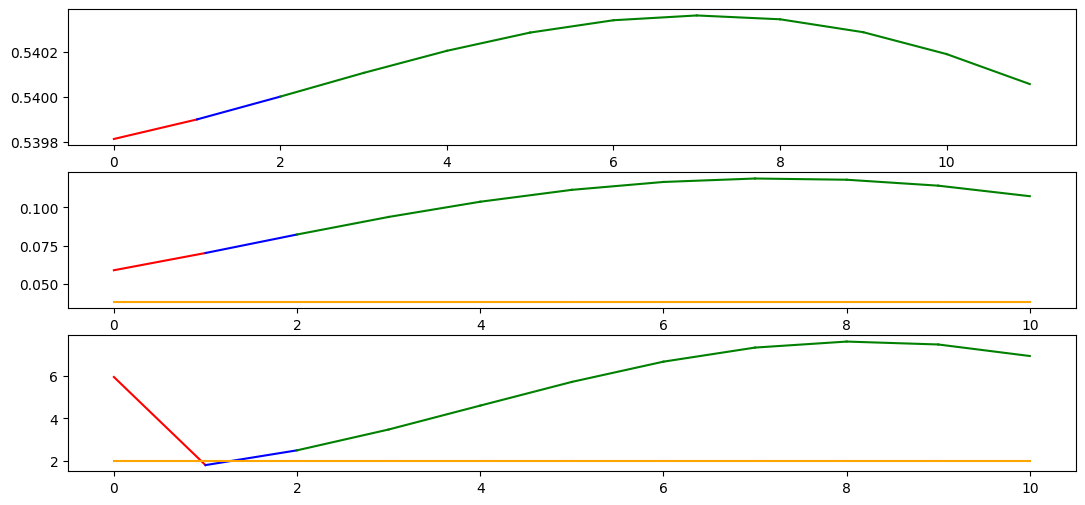

In [39]:
speed_threshold = np.sqrt((threshold_x)**2 + (threshold_y)**2)*30 * 2       #  *3             # *30
elliptic_distance_threshold = 2         # 3
max_dispersion_threshold = 0.01                                                 # 0.01

'''Estimate the Time-Range during which given Emotion is Activated: by checking corresponding Action Units Simultaneous Activations'''
# Select **Emotion and its Range:
# emotion_activate_timstamps: [0= happy], [1= sad], [2= angry], [3= fear]
emotion_time_range = [emotion_activate_timstamps[1][0], emotion_activate_timstamps[1][1]]  # Fear

saccades, fixations, saccade_index_list, fixation_index_list, speed_x_list, speed_y_list, saccade_fixation_indicator, elliptic_distance_list, speed_list = estimate_saccades_fixations(iris_relative_coords_interpolated_array[emotion_time_range[0]:emotion_time_range[1],:2], threshold_x, threshold_y, speed_threshold, elliptic_distance_threshold, max_dispersion_threshold)


data = pd.DataFrame({'group': pd.Categorical(['a', 'b', 'b', 'a', 'a', 'a', 'b', 'b'])})
colours = {0: 'red', 1:'blue', 2:'green'}
labels = {0: 'None', 1:'Fixation', 2:'Saccade'}

# plt.figure(figsize=(13,4))
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(13,6))

for i in range(0, 0 + len(iris_relative_coords_interpolated_array[2:-2, 0])-1):     # [2:-2,0]
    # plt.plot([i, i+1],[iris_relative_coords_interpolated_array[2+i,0], iris_relative_coords_interpolated_array[2+i+1,0]], color=colours[saccade_fixation_indicator[i]])
    
    ax1.plot([i, i+1],[iris_relative_coords_interpolated_array[2+i, 0], iris_relative_coords_interpolated_array[2+i+1, 0]], color=colours[saccade_fixation_indicator[i]])
    ax2.plot([i, i+1],[speed_list[i], speed_list[i+1]], color=colours[saccade_fixation_indicator[i]])
    ax2.plot([i, i+1], [speed_threshold, speed_threshold], color='orange')
    ax3.plot([i, i+1],[elliptic_distance_list[i], elliptic_distance_list[i+1]], color=colours[saccade_fixation_indicator[i]])
    ax3.plot([i, i+1], [elliptic_distance_threshold, elliptic_distance_threshold], color='orange')
    


plt.xlabel('Frame')
plt.ylabel('X-coordinate')
plt.show()



1379


### Saccades & Fixation Info: Store Summaries and Features into CSV File

In [121]:
# Saccades & Fixation Info: Store Summaries and Features

# SACCADES:

num_saccades = len(saccades)

# saccade rate:
saccades_per_unit_time = num_saccades / len(iris_relative_coords_interpolated_array[:,:2])

# saccade rate (for Emotion: within AU activation range):
# saccades_per_unit_time = num_saccades / len(iris_relative_coords_interpolated_array[emotion_time_range[0]:emotion_time_range[1],:2])

print('Number of Saccades:', num_saccades)
print('Saccade Rate (Hz): ', saccades_per_unit_time)

# total_sac_time = saccades[num_saccades-1][-1][2] - saccades[0][-1][2]
# saccade_rate = num_saccades/total_sac_time
# print(f'Saccade Rate: {saccade_rate} Hz')

saccade_info = []

k=0
for group in saccades:
    group_array = np.array(group)
    group_size = len(group)
    # group_time_len = group[group_size-1][2] - group[0][2]      # This Saccades Group's Time Duration
    group_time_len = del_time * group_size
    print('Saccade Group Time Duration: ', group_time_len)

    #sacc_frame_speed_list = []

    # if group_size>1:
    #     for i in range(1, group_size):
    #         frame_time_diff = group[i][2] - group[i-1][2]
    #         distance_cover,_ , _ = calculate_distance(group[i][:2], group[i-1][:2])
    #         sacc_frame_speed = distance_cover/frame_time_diff
    #         sacc_frame_speed_list.append(sacc_frame_speed)
    #         print('group speeds:', sacc_frame_speed)  
    # else:
    #     sacc_frame_speed_list.append(0)
    #     print('group speeds:', 0)
    
    group_saccade_max_speed = max(group_array[:, 2])              #
    print('Group Saccade Speed: ', group_saccade_max_speed)

    saccade_group_info = [group_time_len, group_saccade_max_speed]

    saccade_info.append(saccade_group_info)

print('saccade info: ', saccade_info)

saccade_info_array = np.array(saccade_info)     #

max_saccade_duration = max(saccade_info_array[:,0])               #np.max([i[0] for i in saccade_info])
mean_saccade_duration = np.mean(saccade_info_array[:,0])          #np.mean([i[0] for i in saccade_info])
sd_saccade_duration = np.std(saccade_info_array[:,0])             #np.std([i[0] for i in saccade_info])

max_saccades_speed = max(saccade_info_array[:,1])                 #np.max([i[1] for i in saccade_info])

saccades_csv_fields = ['Saccades Time Lengths:', 'Max Saccades Speed:']
saccades_csv_filename = "saccades_info.csv"  

with open(saccades_csv_filename, "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(('Number of Saccades: ', num_saccades))
    writer.writerow(('Saccade Rate (Hz): ', saccades_per_unit_time))
    writer.writerow(('Peak Saccadic Velocity: ', max_saccades_speed))
    writer.writerow(('Max Saccade Duration: ', max_saccade_duration))
    writer.writerow(('Mean Saccade Duration: ', mean_saccade_duration))
    writer.writerow(('Std Saccade Duration: ', sd_saccade_duration))
    
    writer.writerow(saccades_csv_fields)
    writer.writerows(saccade_info)


#-------------------------------------------------------------------------------------------------------

# FIXATIONS:
num_fixations = len(fixations)
fixation_per_unit_time = num_fixations / len(iris_relative_coords_interpolated_array[emotion_time_range[0]:emotion_time_range[1],:2])

print('Number of Fixations:', num_fixations)
print('Fixation Rate (Hz): ', fixation_per_unit_time)

# total_fix_time = fixations[num_fixations-1][-1][2] - fixations[0][-1][2]
# fixation_rate = num_fixations/total_fix_time
# print(f'Fixation Rate: {fixation_rate} Hz')

fixation_info = []

for fix_group in fixations:
    fix_group_size = len(fix_group)
    # fix_group_time_len = fix_group[fix_group_size-1][2] - fix_group[0][2]      # This Fixations Group's Time Duration
    fix_group_time_len = del_time * fix_group_size
    print('Fixation Group Time Duration: ', fix_group_time_len)

    fixation_group_info = [fix_group_time_len]

    fixation_info.append(fixation_group_info)

print('Fixation info: ', fixation_info)


max_fixation_duration = max(fixation_info)         #max([i[0] for i in fixation_info])
mean_fixation_duration = np.mean(fixation_info)    #np.mean([i[0] for i in fixation_info])
sd_fixation_duration = np.std(fixation_info)       #np.std([i[0] for i in fixation_info])

fixation_csv_fields = ['Fixation Time Lengths:']
fixation_csv_filename = "fixation_info.csv"  

with open(fixation_csv_filename, "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(('Number of Fixations: ', num_fixations))
    writer.writerow(('Fixation Rate (Hz): ', fixation_per_unit_time))
    writer.writerow(('Max Fixation Duration: ', max_fixation_duration))
    writer.writerow(('Mean Fixation Duration: ', mean_fixation_duration))
    writer.writerow(('Std Fixation Duration: ', sd_fixation_duration))
    
    writer.writerow(fixation_csv_fields)
    writer.writerows(fixation_info)


Number of Saccades: 1
Saccade Rate (Hz):  0.0035211267605633804
Saccade Group Time Duration:  0.075
Group Saccade Speed:  0.0875889897523163
saccade info:  [[0.075, 0.0875889897523163]]
Number of Fixations: 2
Fixation Rate (Hz):  0.007042253521126761
Fixation Group Time Duration:  0.5166666666666666
Fixation Group Time Duration:  1.7416666666666667
Fixation info:  [[0.5166666666666666], [1.7416666666666667]]


### Polynomial Regression for Screen Gaze Detection Mapping:

In [ ]:
# Fitting Polynomial Regression to the dataset
from sklearn.preprocessing import PolynomialFeatures
 
poly = PolynomialFeatures(degree=2)     # '2nd Degree' Polynomial
X_poly = poly.fit_transform(X)
 
poly.fit(X_poly, y)


### Plotting Fixation Screen Gaze Heatmap

Cover image with heatmap overlay


Text(0, 0.5, 'Screen Y-direction (1080 px)')

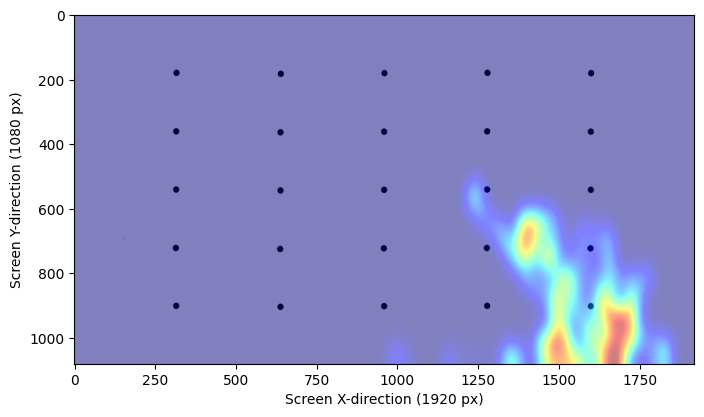

In [337]:
from scipy.ndimage import gaussian_filter

cover_img = plt.imread('Screen Calliberation Points Image _ Gaze Tracking.png')

grid = [1080, 1920]         # height, width of the loaded image
heatmap_detail = 0.02       # this will determine the gaussian blur kerner of the image (higher number = more blur)

gaze_on_surf_x = (iris_relative_coords_interpolated_array[:, 0] - 0.43 ) / 0.15     # normalizing values from actual range along x to (0-1)
gaze_on_surf_y = (iris_relative_coords_interpolated_array[:, 1] + 0.065 ) / 0.06    # normalizing values from actual range along y to (0-1)
gaze_on_surf_y = 1 - gaze_on_surf_y     # Flip y-data


# make the 2D-Histogram: divide into 2D-Bins of same size as of grid (here Screen Dimension)
hist, x_edges, y_edges = np.histogram2d(        # hist: The 2D histogram representing the density of gaze points in each bin
    gaze_on_surf_y,
    gaze_on_surf_x,
    range=[[0, 1.0], [0, 1.0]],
    density=False, 
    bins=grid
)

# Gaussian Blur Kernel as a function of grid/surface size
filter_w = int(heatmap_detail * grid[1]) // 2 * 2 + 1           # Standard Deviation for Gaussian kernel: along x & y
filter_h = int(heatmap_detail * grid[0]) // 2 * 2 + 1
heatmap = gaussian_filter(hist, sigma=(filter_w, filter_h), order=0)

# display the histogram and reference image
print("Cover image with heatmap overlay")
plt.figure(figsize=(8,8))
plt.imshow(cover_img)
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.xlabel('Screen X-direction (1920 px)')
plt.ylabel('Screen Y-direction (1080 px)')
# plt.axis('off');



Text(0, 0.5, 'Normalized Y-coordinate')

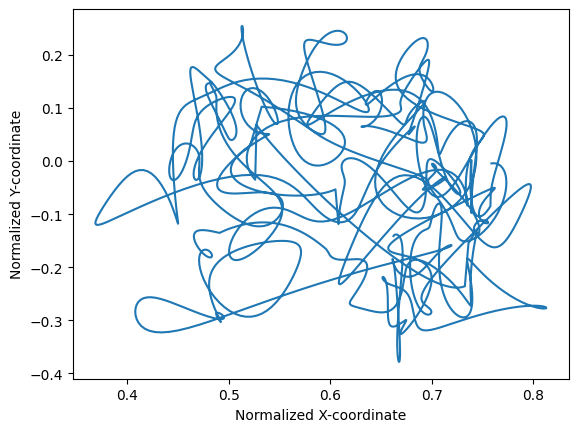

In [251]:
plt.plot(gaze_on_surf_x, 1-gaze_on_surf_y)
plt.xlabel('Normalized X-coordinate')
plt.ylabel('Normalized Y-coordinate')

### Saurabh Chatterjee
### chatterjeesaurabh38@gmail.com